In [1]:
import numpy as np
from numpy import linalg as LA
from scipy.stats import bernoulli
from scipy.stats import beta
import time
import matplotlib.pyplot as plt
import random
import networkx as nx
import scipy as sp

# Setting up the environment

In [2]:
# variables that determine how large the networks will be 
# The values given are typical values, however they will be changed multiple times later on in the code
global nodes
nodes = 700
conections = 3

# Variables that determine how many nodes will be ordered in testing (top)
# and how large the dataset will be (trials)
global top, trials
top = int(100)
trials = 500

In [3]:
# Function to determin the Reputation of n nodes
def rho(n):
    return np.random.uniform(0,1,n)

# Function that determines the transmisibility of 1 message with distribution given bellow
def Tran():
    #return beta.rvs(2,5)
    return np.random.uniform(0.2,0.8)

# function that determines the infectious of a message with node Reputation R, and message Transmisibility T
def func(R, T):
    return R*T

In [4]:
# A random function that has the potenital to take any function monotonic in R and T
def rand_func(r,t, choice = "old" ):
    
    global V, R, RO, T, TO
    
    # If we start a new function we reset all the saved values 
    if choice == "new":
    
        V = np.array([])
        R = np.array([])
        RO= np.array([])
        T = np.array([])
        TO= np.array([])
        return
    # Now deal with the case that we are adding our first value
    n = len(V)
    if n == 0:
        R = np.array([r])
        T = np.array([t])
        RO = np.array([0])
        TO = np.array([0])
        
        v = np.random.uniform(0,1)
        V = np.array([v])
        
        return bernoulli.rvs(v)
    
    # Now we place the new values of r and t into the already existing lists I and T
    # the values rp and tp will be the position such that r or t is not bigger than the values in the list
    # if the values are equal, rE and tE will be the position such that r or t stop equaling r or t
    rE = n    
    rp = n
    for p in range(0,n):
        if R[p]>=r:
            rp = p
            if R[p] == r:
                for E in range(p,n):
                    if R[E]!= r:
                        rE = E
                        break
            else:
                rE = rp
            break
            
    tE = n    
    tp = n
    for p in range(0,n):
        if T[p]>=t:
            tp = p
            if T[p] == t:
                for E in range(p,n):
                    if T[E]!= t:
                        tE = E
                        break
            else:
                tE = tp
            break
      
    # Now we find all the pairs of values such that both r and t are lower 
    # Every value in R has an index number stored in RO, that being the "time" in whihc the value was added
    # For the first value this is 0, for the second this is 1, and so on. 
    # The index number of the value being added is n
    # The same is true for the transmisability value t
    
    Lower = np.array([])
    
    for lr in range(0,rE):
        Rcheck = RO[lr]
        for lt in range(0,tE):
            Tcheck = TO[lt]
            
            if Tcheck == Rcheck:
                Lower = np.append(Lower, int(Rcheck))
     
    Upper = np.array([])
    for lr in range(rp,n):
        Rcheck = RO[lr]
        for lt in range(tp,n):
            Tcheck = TO[lt]
            
            if Tcheck == Rcheck:
                Upper = np.append(Upper, Rcheck)
                
    
    # The value f(i,t) must be greater than all the elements in Lower and less than all the values in Upper
    # Find the min and max of these sets
    
    ML = 0
    mU = 1
    for L in Lower:
        if V[int(L)]> ML:
            ML = V[int(L)]
            
    for U in Upper:
        if V[int(U)]< mU:
            mU = V[int(U)]
    
    R = np.insert(R ,rp,r)
    RO= np.insert(RO,rp,n)
    T = np.insert(T ,tp,t)
    TO= np.insert(TO,tp,n)
    v = np.random.uniform(ML,mU)
    V = np.append(V,v)
    
    
    return v

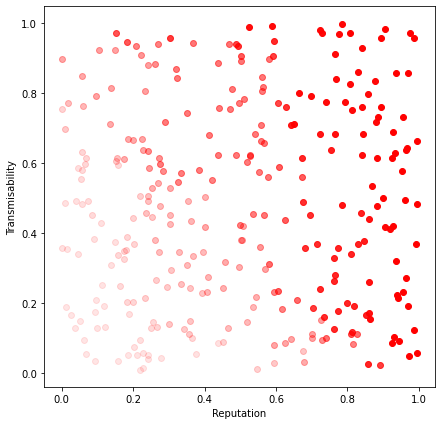

In [5]:
# This plots the values of the random function. The darker the color the higher the value of f(R,T)
global V
test = rand_func(0,0,choice="new")

plt.figure(figsize=(7,7))
for j in range(0,300):
    r = np.random.uniform(0,1)
    t = np.random.uniform(0,1)
    test = rand_func(r,t)
    test = V[j]
    plt.scatter(r,t,color = "red", alpha = (0.1 + 0.9*test))
plt.xlabel("Reputation")
plt.ylabel("Transmisability")
plt.show()

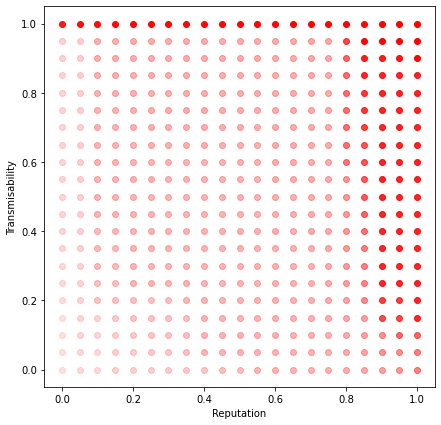

In [6]:
# The same as before but more ordered
global V
R = np.arange(0,1.05,0.05)
T = np.arange(0,1.05,0.05)
li=list([])
for r in R:
    for j in T:
        li.append((r,j))
        
test = rand_func(0,0,choice="new")

plt.figure(figsize=(7,7))
plt.xlabel("Reputation")
plt.ylabel("Transmisability")
tind = 0
while len(li)!=0: 
    x = random.randint(0, len(li)-1)
    r = li[x][0]
    t = li[x][1]
    del li[x]
    test = rand_func(r,t)
    test = V[tind]
    tind += 1
    plt.scatter(r,t,color = "red", alpha = (0.1 + 0.9*test))
plt.show()
    

# Making the Network
This is a function that makes a network. It outputs the matrix and the Reputations of each node. The values N_I are Reputation. (This was done before I swapped the naming convention to Reputation). 

In [7]:
# A network will be represented by a matrix. 1 in the poistion i,j means nodes i and j are connected
# Note if i,j = 1, then j,i=1
def make_grid(n,m):
    N_I = rho(n)                  # Randomly generate the Influencer scores with distribution Rho
    N_O = np.zeros(n)             # N_I will be used to count how many connections exist with each node

#    We start by generating a matrix of size nxn, where no nodes are connected
#    we connect the first two nodes, then go iteritavly conecting new nodes to the alreadye existing nodes
    Network = np.zeros([n,n])
    Network[0,1] = 1
    Network[1,0] = 1
    
    N_O[0:2] = 1
    G_W = N_I[0]+N_I[1] 
    
#    i represents each new node to be added
#    We need to add the aditonal weight to the global weight at the end of each run,
#    so it is counted up as we go and then add it on at the end (G_W + G_W_ADD)
    for i in range(2,n):
        
        G_W_ADD = 0
        for j in range(0,i):
            p = N_O[j]*N_I[j]*m/G_W       # Find probability
            if p >= 1:                    # Values higher than 1 give errors
                connect = 1
            else:
                connect = bernoulli.rvs(p) 
                      
            if connect:                   
                G_W_ADD += N_I[i] + N_I[j] # Increase the global weight
                Network[i,j] = 1           # Conect the nodes
                Network[j,i] = 1
                N_O[i] += 1                # Increase their orders
                N_O[j] += 1 
        G_W += G_W_ADD       # Once i has conected to all nodes that it will conect to, update the global weight
            
    return [Network, N_I, N_O]

## Plotting some graphs
#### Number of conections of nodes with varrying fitness

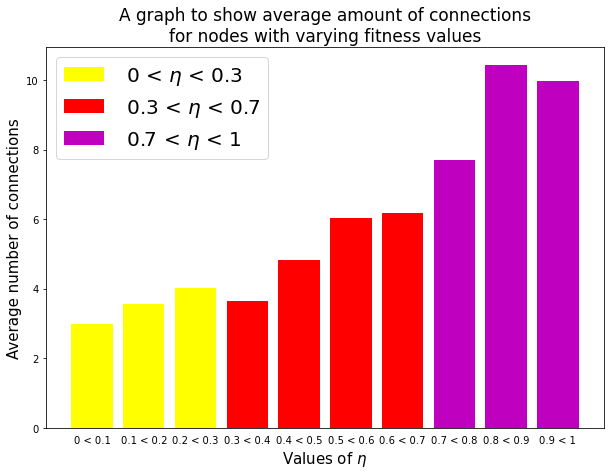

In [8]:
# We will make multiple "small" graphs with 100 nodes and number of graphs gra
global nodes, net, N_I, N_O
nodes = 100
conections = 3
gra = 10
# In the report I used gra = 50, but it takes a while, gra = 10 gives a pretty good picture
# gra = 50


hist = np.zeros([10,2])
for g in range(0,gra):
    [net, N_I, N_O] = make_grid(nodes,conections )
    for i in range(0,nodes):
        s = sum(net[i,:])
        for t in range(0,10):
            if (N_I[i] > t*0.1) and (N_I[i]<(t+1)*0.1):
                hist[t,0] += s
                hist[t,1] +=1
hist[:,0]= hist[:,0]/hist[:,1]  

x1 = ["0 < 0.1","0.1 < 0.2","0.2 < 0.3"]
x2 = ["0.3 < 0.4","0.4 < 0.5","0.5 < 0.6","0.6 < 0.7"]
x3 = ["0.7 < 0.8","0.8 < 0.9","0.9 < 1"]
plt.figure(figsize=(10,7))
plt.bar(x1,hist[0:3,0], color = "yellow", label = " 0 < $\eta$ < 0.3")
plt.bar(x2,hist[3:7,0], color ="r",label = " 0.3 < $\eta$ < 0.7")
plt.bar(x3,hist[7:10,0], color = "m",label = " 0.7 < $\eta$ < 1")
plt.legend(fontsize = 20)
plt.title("A graph to show average amount of connections\nfor nodes with varying fitness values", fontsize = 17)
plt.xlabel("Values of $\eta$", fontsize = 15)
plt.ylabel("Average number of connections", fontsize = 15)
plt.tick_params(bottom= False)
plt.show()

#### Connectivity versus time 
We want to plot the connectivity versus time for nodes with different fitness. In the report, I specifically chose which nodes. However below is something that will pick them automatically, though you can still manually select which nodes to plot if you want.

In [9]:
global nodes, net, N_I, N_O
nodes = 700
conections = 3

[net, N_I, N_O] = make_grid(nodes,conections )

# For the report I made a graph with 10000 nodes, though running it takes a while
# nodes = 10000
# conections = 3

# [net, N_I, N_O] = make_grid(nodes,conections )

In [10]:
# This is used to automatically select wich nodes to plot
global N_I
if N_I[0]<N_I[1]:
    i2 = N_I[0]
    b2 = 0
    t2 = 1
else:
    i2 = N_I[1]
    b2 = 1
    t2 = 0
i10 = i2
t10 = t2
for i in range(0,10):
    if N_I[i]>i10:
        i10 = N_I[i]
        t10 = i
i50 = i10
t50 = t10
for i in range(10,50):
    if N_I[i]>i50:
        i50 = N_I[i]
        t50 = i
        

In [11]:
# This is used to spesfically chose nodes to plot, this prints out the values of Reputation for the first 30 nodes
# I used this to select which nodes to plot
# print(N_I[0:30])

In [12]:
# By looking at the values above, select which ones you wish to plot
# b2 = 0
# i2 = N_I[b2]
# t10 = 1
# i10 = N_I[t10]
# t50 = 2
# i50 = N_I[t50]

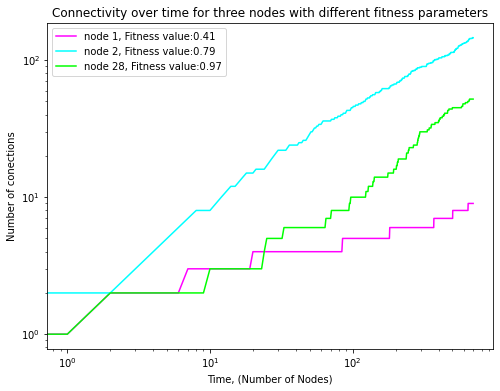

In [13]:
# The "time" a node is added can be considered by it's own index, so node 5 was added 5th  (technically 6th because of node 0)
# To calculate the conectivity at any given time t, we can sum the conections made before time t
# So the conectivity of node k at time t is equal to the sum of conections between node k and nodes added before t

count2 = np.zeros(nodes)
count2[0]=net[b2][0]
count10 = np.zeros(nodes)
count10[0]=net[t10][0]
count50 = np.zeros(nodes)
count50[0]=net[t50][0]
for i in range(1,nodes): # cumulatively sum all the connections
    count2[i] = count2[i-1]+net[b2,i]
    count10[i] = count10[i-1]+net[t10,i]
    count50[i] = count50[i-1]+net[t50,i]
    
plt.figure(figsize=(8,6))
plt.loglog(np.arange(0,nodes),count2,  color = "fuchsia", label = "node " + str(b2)  + ", Fitness value:" + str(round(i2,2)))
plt.loglog(np.arange(0,nodes),count10, color = "aqua", label = "node " + str(t10) + ", Fitness value:" + str(round(i10,2)))
plt.loglog(np.arange(0,nodes),count50, color = "lime", label = "node " + str(t50) + ", Fitness value:" + str(round(i50,2)))
plt.xlabel('Time, (Number of Nodes)')
plt.ylabel('Number of conections')
plt.legend()
plt.title("Connectivity over time for three nodes with different fitness parameters")
plt.show()

# Drawing the Network

In [14]:
# This is a function used to draw a graph
def draw_graph(graph, labels=None, graph_layout='shell',
               node_size=1, node_color='cornflowerblue', node_alpha=None,
               node_text_size=20,
               edge_color='black', edge_alpha=0.7, edge_tickness=0.1,
               edge_text_pos=0.3,
               text_font='sans-serif'):

    global net, N_I, size, lab, bigger
     
   
    # create networkx graph
    G=nx.Graph()
    
    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
    
    # these are different layouts for the network you may try
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)
    
    # select the size of graph
    if bigger == 0:
        plt.figure(figsize=(10,7))
    if bigger == 1:
        plt.figure(figsize=(15,10))
        
    # This is used to draw the graph. The colours will be added after
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, alpha=node_alpha, node_color="white")
    
    # We colour over the top of all the nodes depending on their reputation
    for i in range(0,size):
        if sum(net[i]!=0): # Check they were conected to the network
            ti = nx.Graph()
            ti.add_edge(i,i)
            if N_I[i]>0.7:
                nx.draw_networkx_nodes(ti,graph_pos,node_size=node_size, alpha=1, node_color="m")
            elif N_I[i]>0.3:
                nx.draw_networkx_nodes(ti,graph_pos,node_size=node_size, alpha=1, node_color="red")
            else:
                nx.draw_networkx_nodes(ti,graph_pos,node_size=node_size, alpha=1, node_color="yellow")

    # draw the edges
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,alpha=edge_alpha,edge_color=edge_color)
    if lab == 1: # add labels 
        nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)

    # show graph
    plt.title("Network with "+ str(size)+" nodes", fontsize = 20)
    plt.show()
    


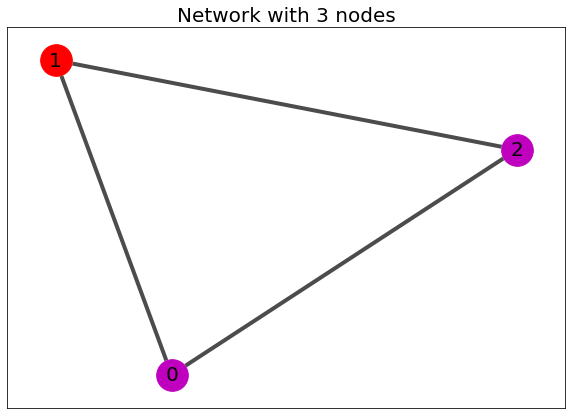

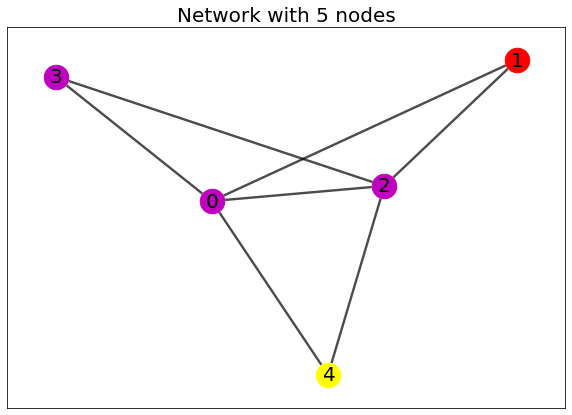

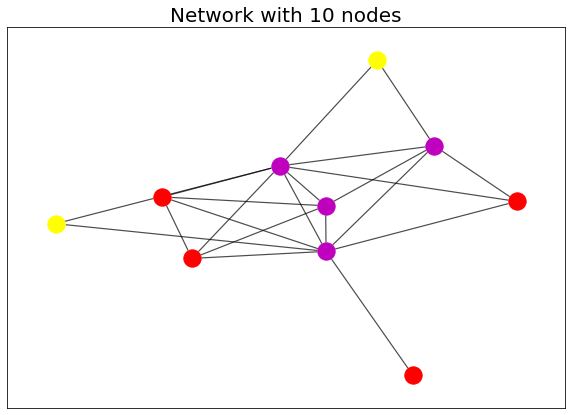

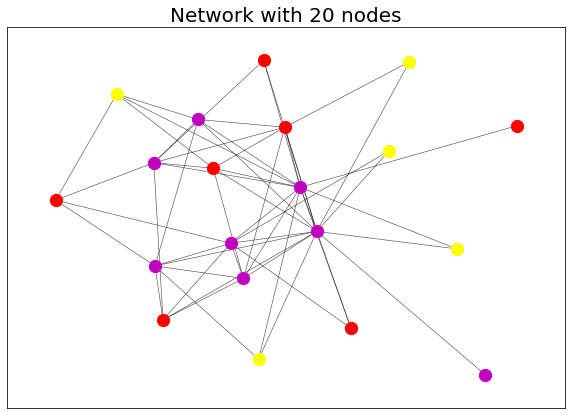

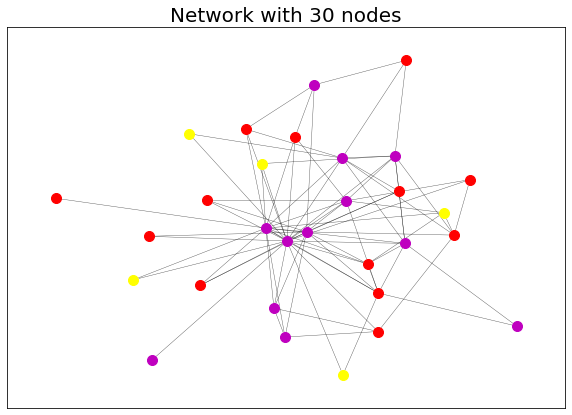

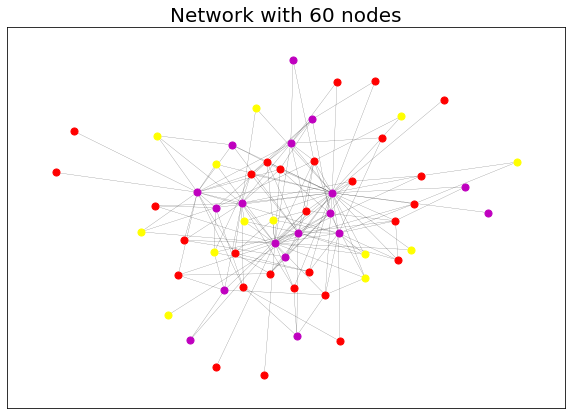

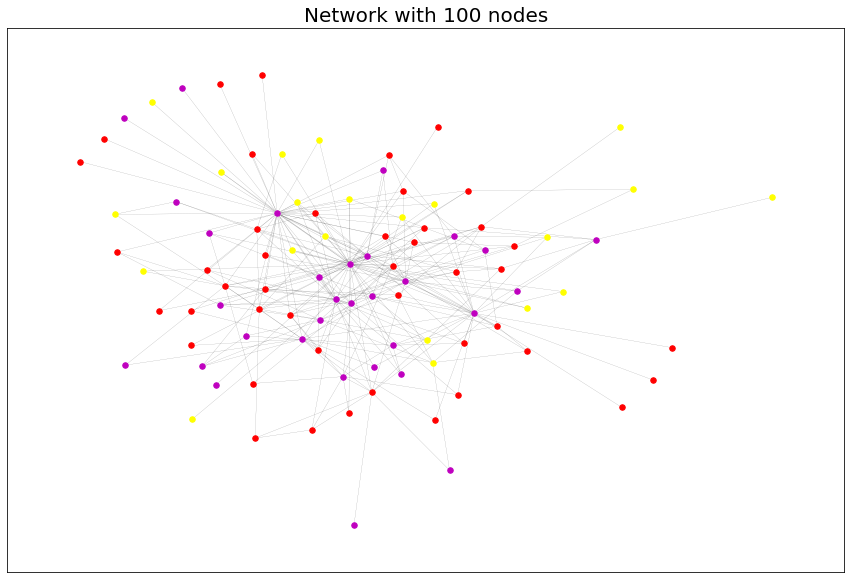

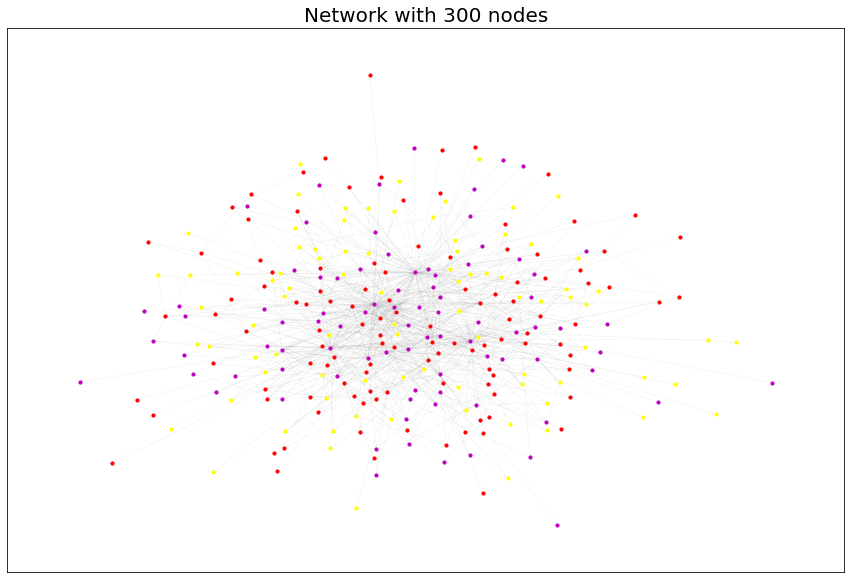

In [15]:
global lab, size, bigger
bigger = 0
lab = 1
for size in [3,5,10,20,30,60,100,300]:
    if size > 5:
        lab = 0
    if size > 60:
        bigger = 1
    graph = []
    for i in range(0,size - 1):
        for j in range(i+1,size):
            if net[i,j]==1:
                graph.append((i,j))
    #draw_graph(graph,node_size= 1000,edge_tickness=1) # This will use defualt layout shell
    draw_graph(graph,node_size= (3000/size),graph_layout = 'spring',edge_tickness=(12/size))



# Modeling spead
Spread carries out the propagation of a message. It starts at the origin and uses a Bernoulli trial with probability func(R,T) to see if each of its connected nodes becomes infected. Then adds these to a list of nodes waiting to infect their neighbours. The program goes through all nodes in the weighting list until no more nodes are waiting. Hence the spread of the message has stopped. 

Values are stored for analysis: how many nodes each node tried to infect and how many they did. 

In [16]:
def spread(origin, tran):
    global nodes, net, N_I
    I = np.zeros(nodes)            #List of infected
    Waiting = [origin]             #List of infected waiting to send message
    I[origin] = 1                  #Initialise the infected with origin node
    
    Interactions = np.zeros(nodes) # will be used for analysis
    Infected     = np.zeros(nodes) 
    
    while Waiting != []:        
        i = Waiting[0]             # take front of the que
        Waiting.remove(i)          # remove it from the que
        f_RT = func(N_I[i],tran)   # determine how infetious it is
        for j in range (0,nodes):  # Check all other nodes to see if they will become infected
            if net[i,j]==1:        # Check i and j are connected
                if I[j]==0:        # Check j is suseptible (not already infected)
                    Interactions[i] += 1         # Tally how many nodes were attempted to be infected
                    infect = bernoulli.rvs(f_RT) # generate 1 or 0 with probability f(R,T)
                    
                    if infect:
                        Infected[i] += 1       # number of nodes infected by node i goes up 1
                        Waiting.append(j)      # j is added to the que of nodes waiting to infect
                        I[j] = 1               # j becomes infected 
                           
    return [I, Interactions, Infected]      

# with diagrams

In [17]:
# A smaller network is used to show the spread
global S_net, S_N_I
S_net = net[0:30,0:30] 
S_N_I = N_I[0:30] 

In [18]:
# same spread function however just prints the network at each stage
def spread_diagrams(origin, tran):
    global S_net, S_N_I
    I = np.zeros(30)         
    Waiting = [origin]       
    I[origin] = 1                
    
    graph = []
    global size
    size = 30
    for i in range(0,size-1):
        for j in range(i+1,size ):
            if S_net[i,j]==1:
                graph.append((i,j))
    draw_graph(graph,node_size= 200,edge_tickness=1) # Prints the original network
    
    
    Infected     = [origin] 
    
    while Waiting != []:
        Interactions = []
        New_infect = []
        i = Waiting[0]
        print("Reputation of purple node:",round(N_I[i],3))
        Waiting.remove(i)
        f_RT = func(N_I[i],tran)
        for j in range (0,30):
            if S_net[i,j]==1:
                if I[j]==0:
                    Interactions.append(j)
                    infect = bernoulli.rvs(f_RT)
                    if infect:
                        Infected.append(j)
                        Waiting.append(j)
                        New_infect.append(j)
                        I[j] = 1
        if len(Interactions)!= 0:
             print("ratio of infection:", round(len(New_infect)/len(Interactions),3))   
        else:
             print("Zero new exposures to uninfected nodes" )
        draw_graph2(graph, Infected, i, Waiting, Interactions , New_infect) # Uses a second graph function to print the spread
    return

# Same as the original draw graph, however it prints differnt colors depending on a nodes role in the infection
def draw_graph2(graph, infected, spreader, waiting_spread, pos_infect, new_infect, labels=None, graph_layout='shell',
               node_size=200, node_color='cornflowerblue', node_alpha=None,
               node_text_size=20,
               edge_color='black', edge_alpha=None, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):

   
    # create networkx graph
    G=nx.Graph()
    
    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
  
    graph_pos=nx.shell_layout(G)
        
    plt.figure(figsize=(10,7))    
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, alpha=node_alpha, node_color="silver", label = "Uninfected")
    

    # Draw plain graph, with no color
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)

    
    I=nx.Graph() # Colour infected nodes
    for i in infected:
        I.add_edge(i,i)
    nx.draw_networkx_nodes(I,graph_pos,node_size=node_size, alpha=node_alpha, node_color="red", label= "Infected")
    
    S=nx.Graph() # Colour the node spreading infection
    S.add_edge(spreader,spreader)
    nx.draw_networkx_nodes(S,graph_pos,node_size=node_size, alpha=node_alpha, node_color="fuchsia", label = "Infected (Spreading)")
    
    WS = nx.Graph() # Colour the already infected nodes
    for i in waiting_spread:
        WS.add_edge(i,i)
    nx.draw_networkx_nodes(WS,graph_pos,node_size=node_size, alpha=node_alpha, node_color="pink", label = "Infected (waiting)")

    PI = nx.Graph() # Colour attempted infections
    for i in pos_infect:
        PI.add_edge(i,i)
    nx.draw_networkx_nodes(PI,graph_pos,node_size=node_size, alpha=node_alpha, node_color="lime", label = "Failed Infection")
    
    NI = nx.Graph() # colour sucseful new infections
    for i in new_infect:
        NI.add_edge(i,i)
    nx.draw_networkx_nodes(NI,graph_pos,node_size=node_size, alpha=node_alpha, node_color="yellow", label = "Sucseful Infection")
    
    plt.legend()
    plt.show()
    


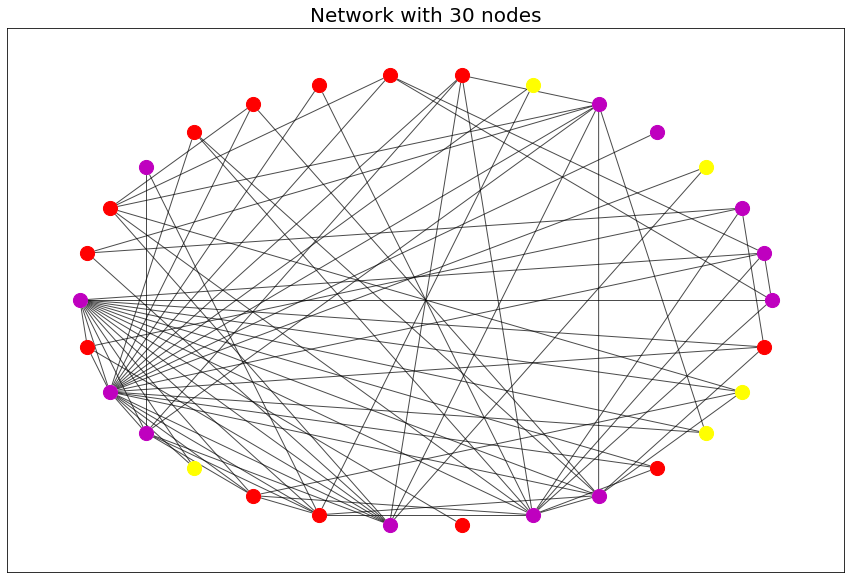

Reputation of purple node: 0.414
ratio of infection: 0.25


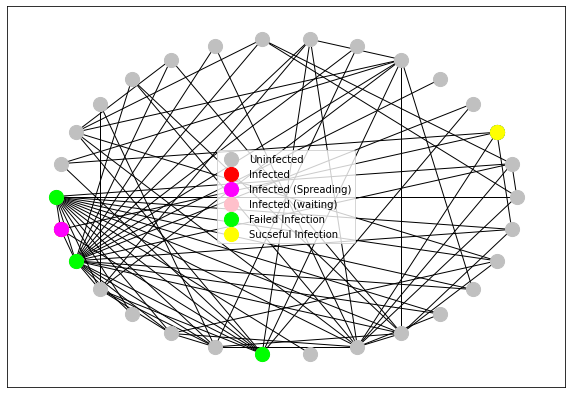

Reputation of purple node: 0.753
ratio of infection: 0.667


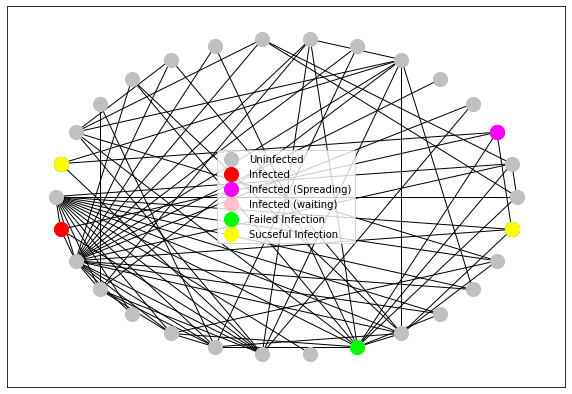

Reputation of purple node: 0.368
ratio of infection: 1.0


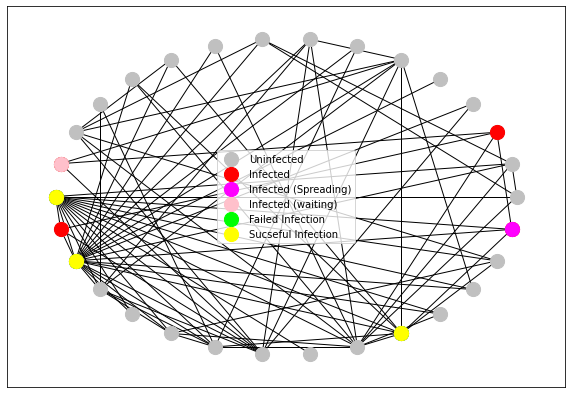

Reputation of purple node: 0.374
ratio of infection: 1.0


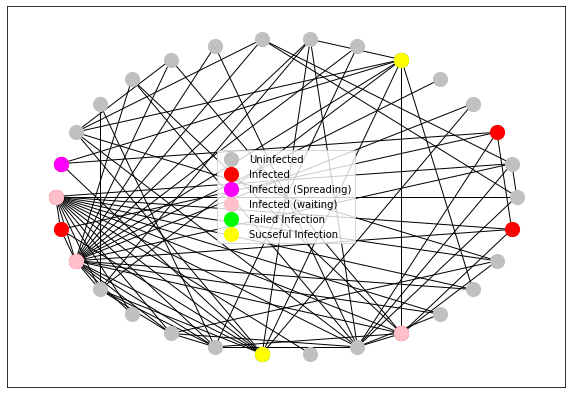

Reputation of purple node: 0.749
ratio of infection: 0.727


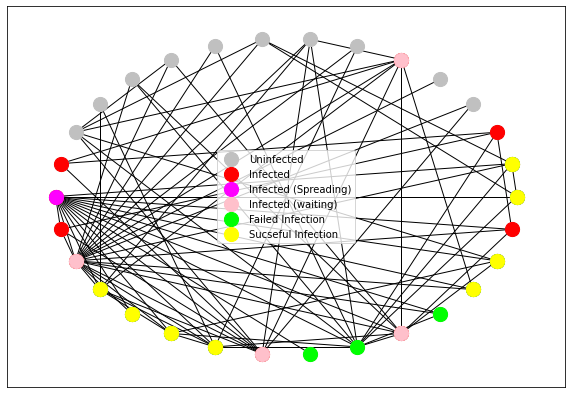

Reputation of purple node: 0.793
ratio of infection: 0.556


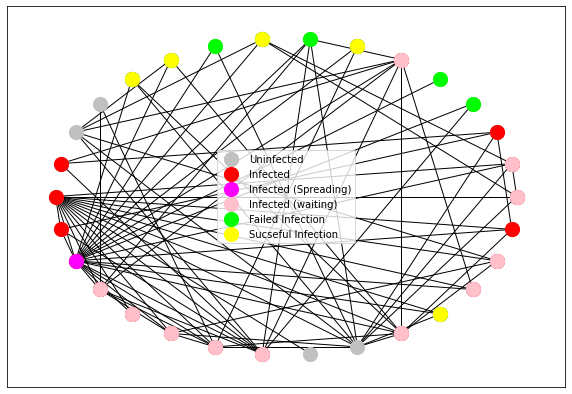

Reputation of purple node: 0.962
ratio of infection: 0.0


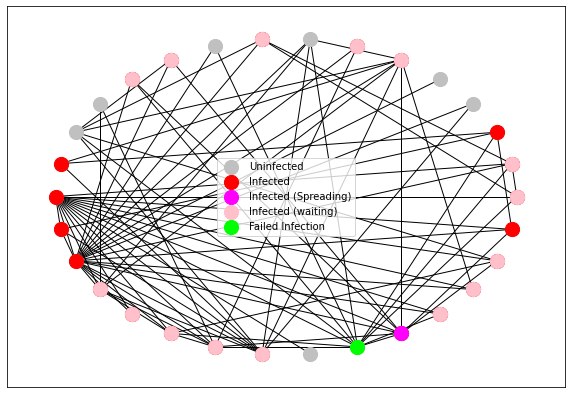

Reputation of purple node: 0.766
ratio of infection: 0.333


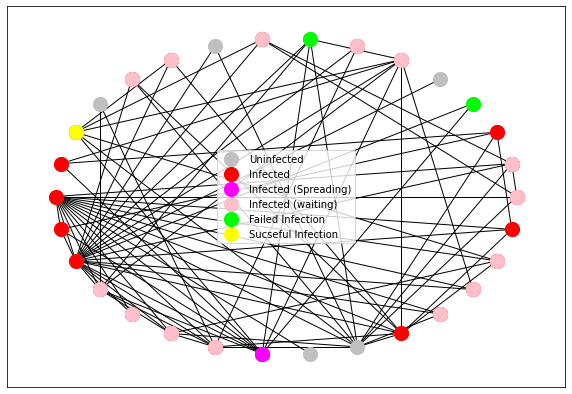

Reputation of purple node: 0.936
ratio of infection: 1.0


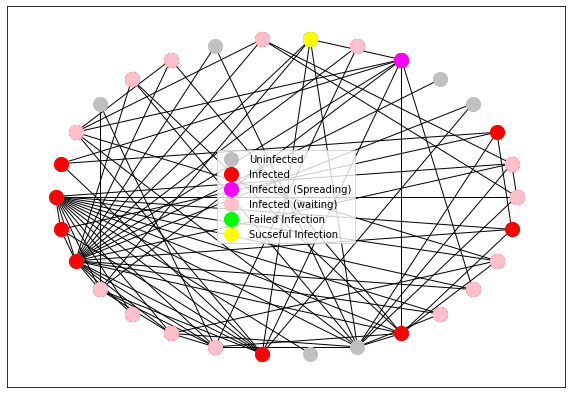

Reputation of purple node: 0.736
ratio of infection: 1.0


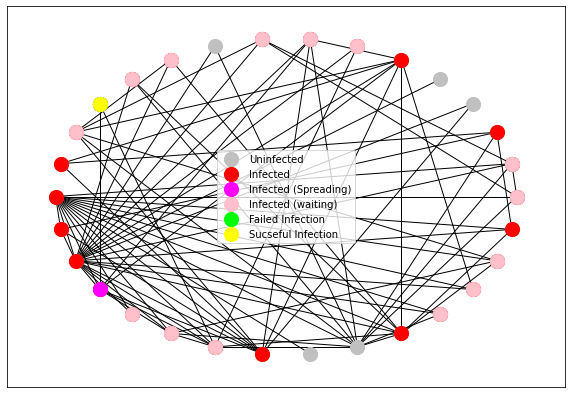

Reputation of purple node: 0.118
Zero new exposures to uninfected nodes


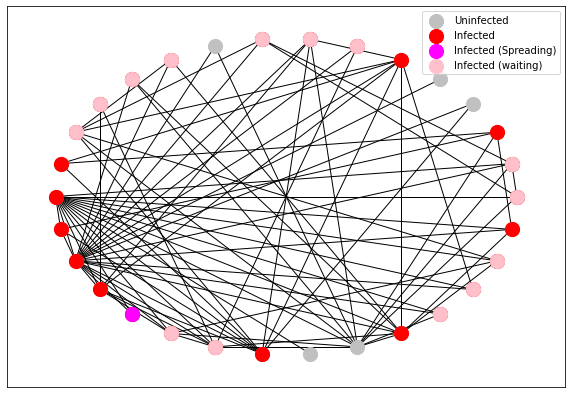

Reputation of purple node: 0.469
ratio of infection: 0.0


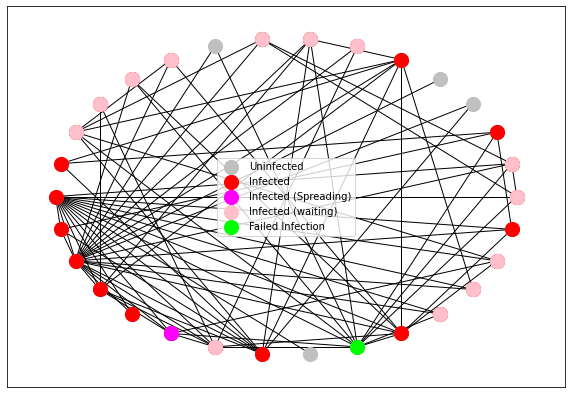

Reputation of purple node: 0.436
ratio of infection: 0.0


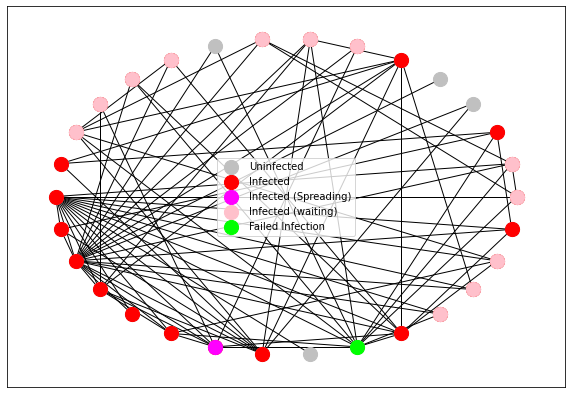

Reputation of purple node: 0.011
Zero new exposures to uninfected nodes


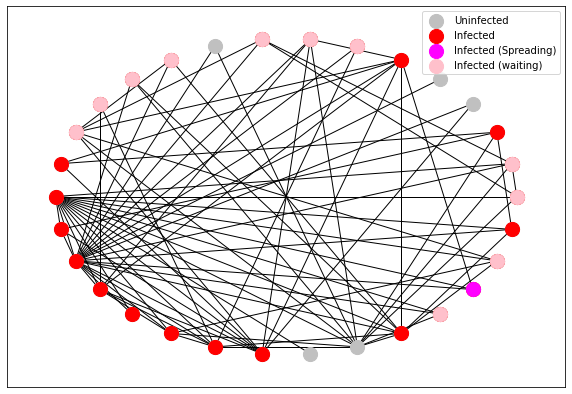

Reputation of purple node: 0.126
Zero new exposures to uninfected nodes


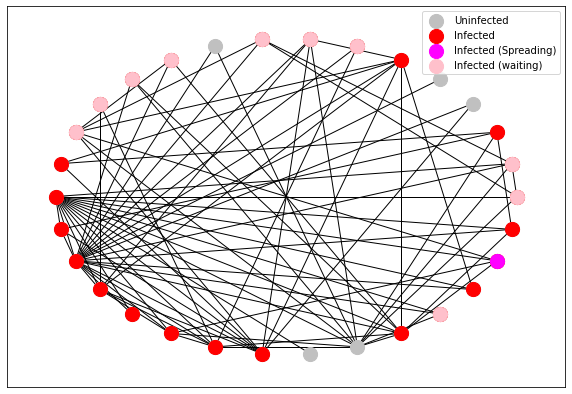

Reputation of purple node: 0.791
ratio of infection: 1.0


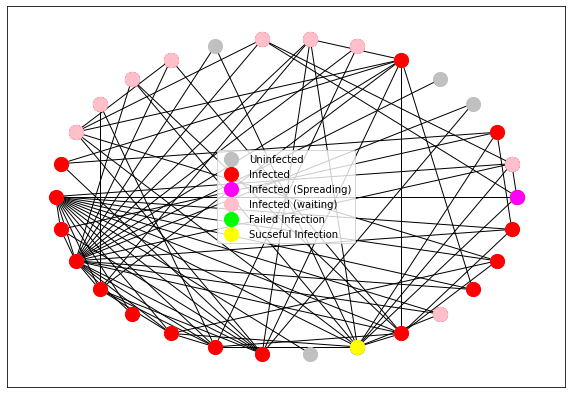

Reputation of purple node: 0.97
Zero new exposures to uninfected nodes


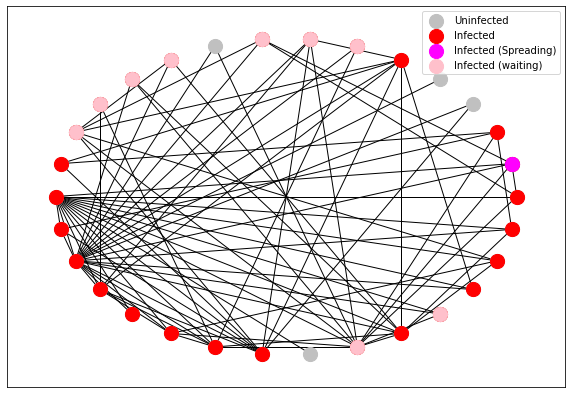

Reputation of purple node: 0.038
Zero new exposures to uninfected nodes


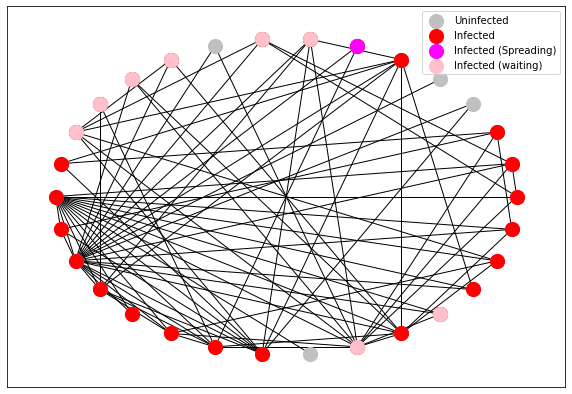

Reputation of purple node: 0.388
Zero new exposures to uninfected nodes


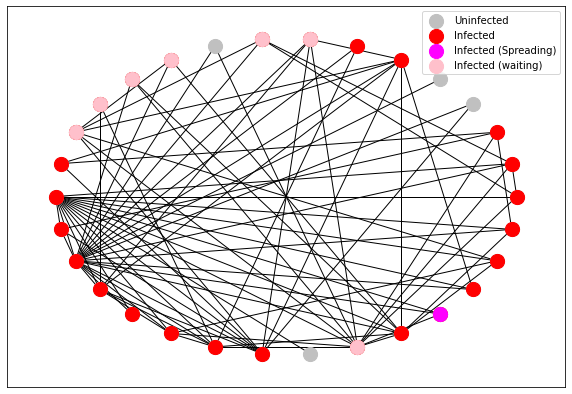

Reputation of purple node: 0.682
Zero new exposures to uninfected nodes


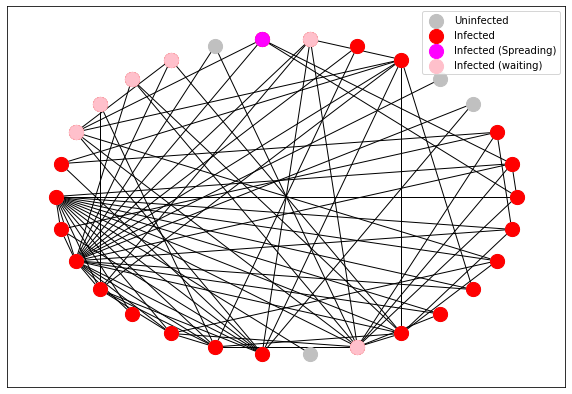

Reputation of purple node: 0.558
Zero new exposures to uninfected nodes


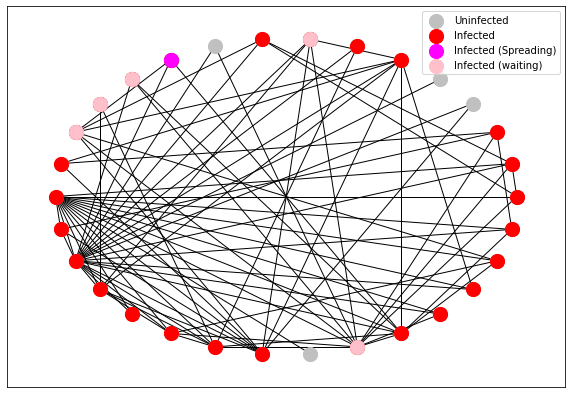

Reputation of purple node: 0.639
Zero new exposures to uninfected nodes


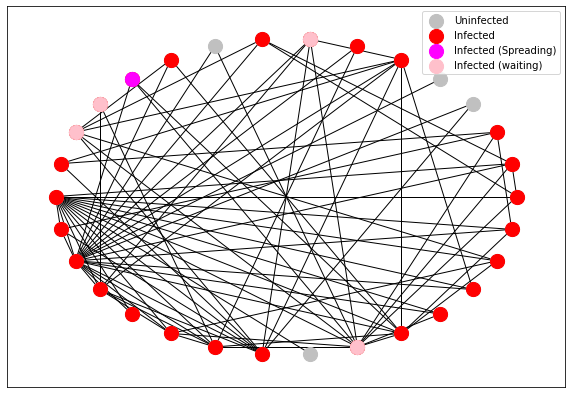

Reputation of purple node: 0.501
Zero new exposures to uninfected nodes


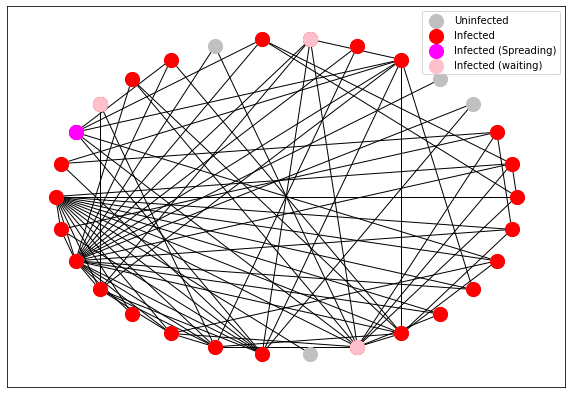

Reputation of purple node: 0.514
Zero new exposures to uninfected nodes


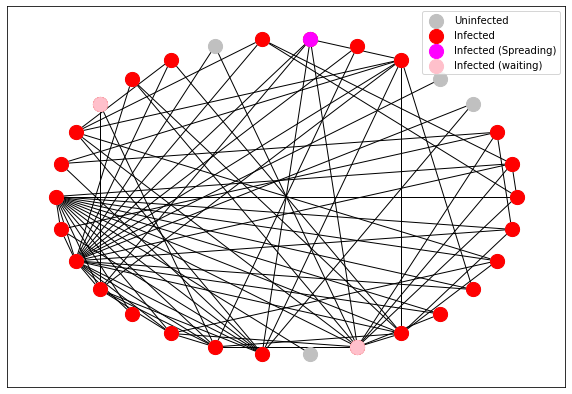

Reputation of purple node: 0.749
Zero new exposures to uninfected nodes


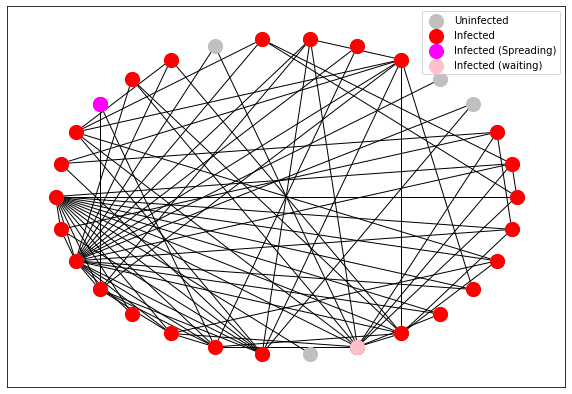

Reputation of purple node: 0.772
ratio of infection: 1.0


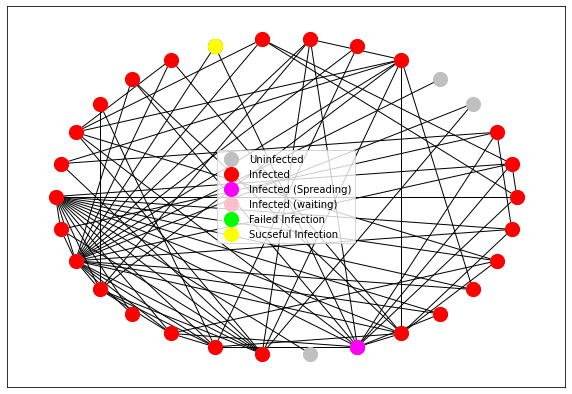

Reputation of purple node: 0.37
Zero new exposures to uninfected nodes


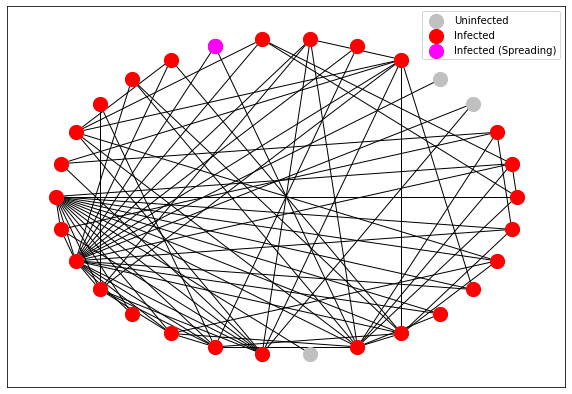

In [19]:
spread_diagrams(1, 0.8)

# Anaylising the spread

Now that we have created a network, we wish to send messages throughout it, observe how these messages interact, and then through analysis, return a guess as to what nodes are more influential than others. As a general rule, we know that a more influential node will infect a higher percentage of its connected nodes than a less influential node. However, we have the problem that the influence of a node is not the only contributing factor. The "transmissibility" of a message also plays a part.

Below are three different methods for inferring the influence scores (or order of). Let the "True Order of Reputation" refer to the order we would place each node if we had the node with the highest reputation at one end and the lowest at the other. 

I measure the accuracy of the methods by their ability to reduce the variance of the "Inferred Order of reputation" versus the True Order of reputation.

A major issue we face is that for any given message is we don't know how transmissible it is. And so it's hard to compare results between different messages. For example, Let Node A send message x to all its connected nodes and infect 50% of them. While Node B sends message y to all its connected nodes and infects 60% of them. We can't just say Node B is more influential than Node A, as message y could be more transmissible than message x.

To overcome this, methods 1 and 2 only make comparisons between nodes when they send the same message. For example, we only compare Node A and B if they both send message x. So if node A sends message x and infects 50% and B sends x and infects 60%, we have some evidence that Node B is more Influential than Node A

Method 3 overcomes the same issue by comparing all the messages Node A sends with All the messages Node B sends. Though every message has different transmissibility, the distribution is the same for each node, so if we compare enough nodes, we should mitigate this effect. 

In [20]:
# al() is used so that all three methods get the data they need from the same messages. 
def al():
    global nodes, top, N_I, trials, net

    # tabel contains top (the value) lists—one for each node. 
    # The list for each node will contain information about every message they sent
    # how many nodes they tried to infect and how many of these were successful. 
    tabel = []
    for make in range(0,top):
        tabel.append([])
     
    # H2H stores the head-to-head comparisons for each node that send the same message.
    # If node i and node j send the same message and node i infects a higher percentage 
    # of its connected nodes, then H2H(i,j) will gain a point. 
    H2H = np.zeros([nodes,nodes])
    
    for test in range(0,trials):

        ratios = []     # used for H2H
        origin= random.randint(0, top-1) # pick the origin
        tran = Tran()                    # pick transmisibility
        [I, Interactions, Infected]  = spread(origin, tran)    # spread the message
        
        # Store relative information in tabel
        t = sum(Infected)
        b = sum(Interactions)
        if b > 0:
            for i in range(0,top):
                if Interactions[i] > 0:
                    tabel[i].append((Interactions[i],Infected[i],b,t))
        
        # For H2H, the ratio of infections is calcualted for each node invloved in the spread of the message
        for i in range(0,nodes):
            if Interactions[i]!=0:   # check it was involved
                ratios.append((Infected[i]/Interactions[i],i)) # add the ratio
        ratios.sort()                # Order them
        
        # ratios will now have all the highest ratios at the end and lowest at the start. 
        # Every node outperformed all the nodes to its left. 
        # Cycle through all the "winners" giving them a point over every node to their left.
        
        for w in range(len(ratios)-1,0,-1): # Cycle through winner
            for l in range(w-1,-1,-1):      # cycle through losers
                if ratios[w][0]>ratios[l][0]: # Check their not equal (important for values of zero)
                    H2H[ratios[w][1],ratios[l][1]] +=1 # add the point
                       
    return [tabel, H2H]


# al2() just makes tabel. It is used when we no longer look at method 1 or 2
def al2():
    global nodes, top, N_I, trials, net, tabel    
    for test in range(0,trials):
        origin= random.randint(0, top-1)
        tran = Tran()
        [I, Interactions, Infected]  = spread(origin, tran)
        t = sum(Infected)
        b = sum(Interactions)
        if b > 0:
            for i in range(0,top):
                if Interactions[i] > 0:
                    tabel[i].append((Interactions[i],Infected[i],b,t))   
    return


# analysis 1 tallies up every time it wins and loses, then orders the ratio of these. 
def anaylsis1():
    global top, N_I, H2H
    wins = np.sum(H2H, axis = 1)[0:top]
    loses= np.sum(H2H, axis = 0)[0:top]
    score= [i/(i+j+1) for i,j in zip(wins,loses)]
    sco_pos = [(i,j) for i,j in zip(score,np.arange(0,top))]
    sco_pos.sort()
    sco_pos.reverse()
    sco_pos1 = [(N_I[i[1]],i[1]) for i in(sco_pos)]
    
    return sco_pos1


# analysis 2 goes through the values in H2H and finds a pair of nodes with the most "confidence"
# that node i has a higher reputation than node j. It does this by comparing their wins to their losses.
# The pair with the biggest difference is the pair we have the most confidence in ordering.
# After placing these nodes into the ordering, it finds the next node we are most confident about ordering 
# relative to the nodes in the order already. This is repeated for all nodes. 

def anaylsis2 ():
    global top, H2H
    wins = H2H[0:top,0:top]
    loses= wins.transpose()
    versus= wins - loses     # versus(i,j) = # wins for i - # wins for j
    global con
    con = abs(versus)        # Confidence
    
    
    ind = index(con,np.max(con))
    con[ind[0], :] = 0
    con[ind[1], :] = 0
    
    if versus[ind]>0:       # Place the two nodes into the order
        order = np.array([ind[0],ind[1]])
    else:
        order = np.array([ind[1],ind[0]])
    ind = (0,0)
#    while ind != (100,100):
    for run in range(0,top):
        # left and right indicat the range that a new value should be placed
        # when left = right we have found the position to place the new value
        left = 0
        right = len(order)
        j = -1               # siginal for confidence(), to find a new node to place 
        while left != right:
            ind = confidence(order[left:right],j) # Confidence returns the pair with most confidence
            if ind == (top,top):                  # or signal to stop
                return order
            i = ind[0]
            j = ind[1]
            # determine wether we move left or right inwards
            if versus[i,j]>0:                   
                left = np.where(order == i)[0][0] +1
            else:
                right= np.where(order == i)[0][0]
        # When left = right, place j
        order = np.insert(order,left,j)
    return order


# Index is used in anaylis 2
# It finds the position in a amrtix that has value val
def index(mat,val):
    for i in range(0,np.shape(mat)[0]):
        for j in range(0,np.shape(mat)[1]):
            if mat[i,j] == val:
                return i,j
            
# Confidence is used to position a new node into order. 
# If finding a new node to place, it returns the pair of nodes (one in and out of order). That has the highest confidence.
# If placing a particular node in order, it finds the node in a given range with the highest confidence.              
def confidence(check, search):
    global con
    global top
    m=-1
    if search == -1: # This is signal to find a new node
        for i in check: # loop through all nodes in order
            for j in range(0,np.shape(con)[0]): # loops through all other nodes
                if j not in check:              # checks the second node isn't already placed in order
                    if con[i,j]>m:              # If this pair has a higher confidence than previous confidence it replaces m
                        m = con[i,j]
                        ind = (i,j)
        if m == -1:                             # If we can't find a pair all nodes are placed
            return (top,top)                    # returns signal to stop running
    # Placing search in the section check
    else:
        for i in check:
            if con[i,search]>m:
                m = con[i,search]   # Find pair with highest confidence
                ind = (i,search)    # return the pair            
    return ind


#analysis 3 averages all the ratio of infections for all nodes. It then orders them
def anaylsis3 ():
    global top, N_I, tabel
    sco_pos=[]
    for i in range(0,top): # loop through all nodes
        if tabel[i] != []: # check it actually sent a message
            divide = 0
            sco = 0
            for message in tabel[i]:
                if message[0] != 0:
                    sco += message[1]/message[0] # add on fraction of infection
                    divide  += 1                 # will be used to average the results
            
            if divide != 0:
                sco_pos.append((sco/divide , i)) # average out over how many messages were sent
            else:
                sco_pos.append((0,i))
        else:
            sco_pos.append((0,i))
      
    sco_pos.sort()
    sco_pos.reverse()
    sco_pos1 = [(N_I[i[1]],i[1]) for i in(sco_pos)] # order the values

    return sco_pos1

In [21]:
global tabel, H2H
tabel,H2H = al()

In [22]:
global top
top = 100

In [23]:
A1_R = anaylsis1()
A2_R = anaylsis2()
A3_R = anaylsis3()

# This finds the order of the "true values"
T_R = [(i,j) 
       for i,j in zip(N_I[0:100],np.arange(0,100))]
T_R.sort()
T_R.reverse()

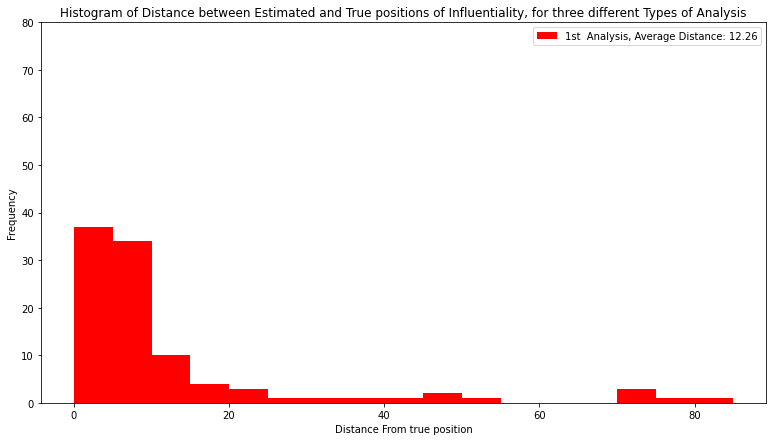

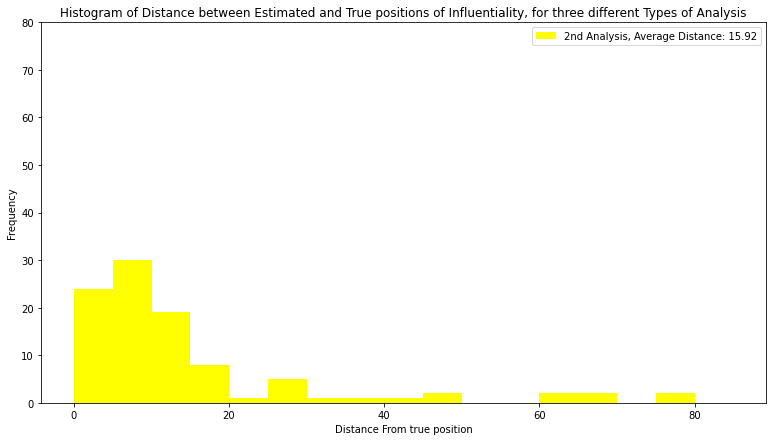

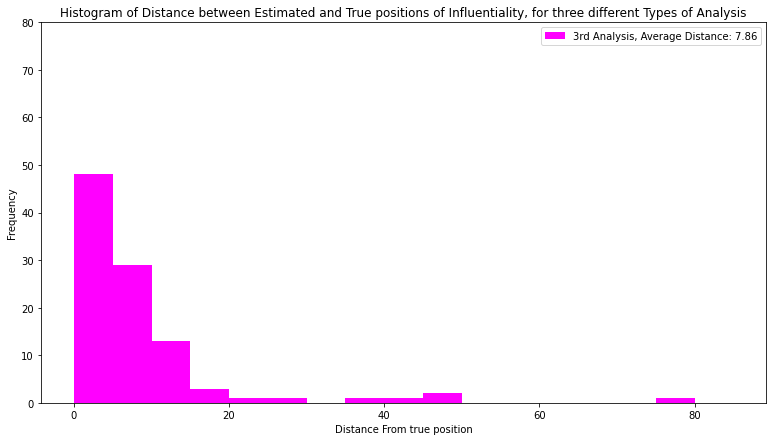

In [24]:
# This finds the diference in the orders from analysis 1,2 and 3 versus the "true order"
global top
# p_dif will store the position diference for each node
p_dif1 = np.zeros(top)
p_dif2 = np.zeros(top)
p_dif3 = np.zeros(top)
for i in range(0,top):
    ti = T_R.index((N_I[i],i))
    
    ei1 = A1_R.index((N_I[i],i))
    p_dif1[i] = abs(ti-ei1)
    
    ei2 = np.where(A2_R== i)[0][0]
    p_dif2[i] = abs(ti-ei2)
    
    ei3 = A3_R.index((N_I[i],i))
    p_dif3[i] = abs(ti-ei3)

# A_PD is the average position differnce     
A_PD1 = sum(p_dif1)/top    
A_PD2 = sum(p_dif2)/top
A_PD3 = sum(p_dif3)/top


# These plot nice historgrams

plt.figure(figsize=(13,7))
plt.hist(p_dif1, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85], alpha=1, color ="red", label = "1st  Analysis, Average Distance: " +str(A_PD1))
plt.legend()
plt.ylim(0,80)
plt.xlabel("Distance From true position")
plt.ylabel("Frequency")
plt.title("Histogram of Distance between Estimated and True positions of Influentiality, for three different Types of Analysis")
plt.show()


plt.figure(figsize=(13,7))
plt.hist(p_dif2, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85], alpha=1, color = "yellow",label = "2nd Analysis, Average Distance: " +str(A_PD2))
plt.legend()
plt.ylim(0,80)
plt.xlabel("Distance From true position")
plt.ylabel("Frequency")
plt.title("Histogram of Distance between Estimated and True positions of Influentiality, for three different Types of Analysis")
plt.show()

plt.figure(figsize=(13,7))
plt.hist(p_dif3, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85], alpha=1, color = "magenta",label = "3rd Analysis, Average Distance: " +str(A_PD3))
plt.legend()
plt.ylim(0,80)
plt.xlabel("Distance From true position")
plt.ylabel("Frequency")
plt.title("Histogram of Distance between Estimated and True positions of Influentiality, for three different Types of Analysis")
plt.show()

# Testing
## Reducing data

In [25]:
global nodes
nodes = 700
conections = 3
# premake 3 networks that are saved and can be called apon
[net1, N_I1, N_O1] = make_grid(nodes,conections )
[net2, N_I2, N_O2] = make_grid(nodes,conections )
[net3, N_I3, N_O3] = make_grid(nodes,conections )

In [26]:
Results = np.zeros([4,3,3,3])

In [27]:
# Only the size 200 for dataset has been used to speed up the computation
# The others can be added back in if desired, just uncoment
global nodes, top, N_I, trials, net, tabel, H2H
for datasize in [(200,1)]:# [(400,0),(200,1),(100,2),(50,3)]:
    trials = datasize[0]
    for network in [(net1,N_I1,0),(net2,N_I2,1),(net3,N_I3,2)]: # loop through networks
        net = network[0]
        N_I = network[1]
        
        T_R = [(i,j) for i,j in zip(N_I[0:100],np.arange(0,100))]
        T_R.sort()
        T_R.reverse()
        
        for dataset in range(0,3): # loop through data sets
            tabel,H2H = al()
            
            # Run the anylisis for each method
            A1_R = anaylsis1()
            A2_R = anaylsis2()
            A3_R = anaylsis3()
                   
            # Find the position differnces and average position diferences
            p_dif1 = np.zeros(top)
            p_dif2 = np.zeros(top)
            p_dif3 = np.zeros(top)
            for i in range(0,top):
                ti = T_R.index((N_I[i],i))
    
                ei1 = A1_R.index((N_I[i],i))
                p_dif1[i] = abs(ti-ei1)
    
                ei2 = np.where(A2_R== i)[0][0]
                p_dif2[i] = abs(ti-ei2)
    
                ei3 = A3_R.index((N_I[i],i))
                p_dif3[i] = abs(ti-ei3)
            
            Results[datasize[1],network[2],dataset,0] = sum(p_dif1)/top
            Results[datasize[1],network[2],dataset,1] = sum(p_dif2)/top
            Results[datasize[1],network[2],dataset,2] = sum(p_dif3)/top
        

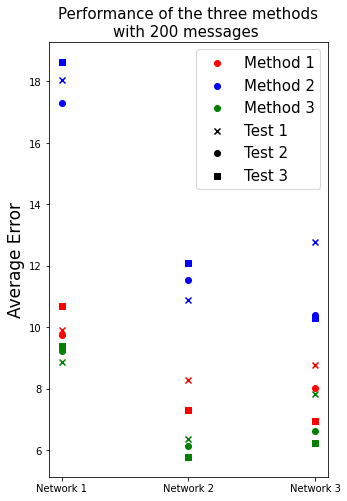

In [28]:
x = ["Network 1","Network 2","Network 3"]
mar = ["x","o","s"]
for datasize in [(200,1)]:#[(400,0),(200,1),(100,2),(50,3)]: # <- if all data set sizes were calculated change here aswell 
    
    plt.figure(figsize=(5,8))
    plt.title("Performance of the three different methods\nwith test data of "+str(datasize[0])+" messages ", fontsize = 15)
    for g in range(0,3):
        for m in range(0,3):
            plt.scatter([x[g]],Results[datasize[1],g,m,0],color = "red", marker = mar[m])
            plt.scatter([x[g]],Results[datasize[1],g,m,1],color = "blue", marker = mar[m])
            plt.scatter([x[g]],Results[datasize[1],g,m,2],color = "green", marker = mar[m])
        
    plt.scatter([],[],label="Method 1",color = "red")
    plt.scatter([],[],label="Method 2",color = "blue")
    plt.scatter([],[],label="Method 3",color = "green")
    plt.scatter([],[],label="Test 1", marker = "x", color = "k")
    plt.scatter([],[],label="Test 2", marker = "o", color = "k")
    plt.scatter([],[],label="Test 3", marker = "s", color = "k")
    plt.ylabel("Average Error", fontsize = 17)
    plt.title("Performance of the three methods\nwith "+str(datasize[0])+" messages ", fontsize = 15)
    plt.legend(fontsize = 15)
    plt.show()

Bellow is a graph of the average results of the three methods as we reduce the data. It would be uninteresting if only data size 400 were used. If you wish to get the rest of the data, you don't have to run the 400 data set again. 

Copy:
for datasize in [200,1),(100,2),(50,3)]:


and rerun the program. This will continue to write onto Results.

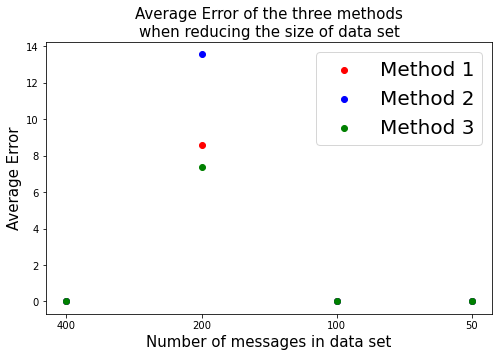

In [29]:

AR = np.zeros([3,4])
AR[:,0]=sum(sum(Results[0,:,:,:]))/9
AR[:,1]=sum(sum(Results[1,:,:,:]))/9
AR[:,2]=sum(sum(Results[2,:,:,:]))/9
AR[:,3]=sum(sum(Results[3,:,:,:]))/9


plt.figure(figsize=(8,5))

x = ["400","200","100","50"]
cl = ["red","blue","green"]
for i in range(0,3):
    plt.scatter(x,AR[i], color = cl[i], label = "Method " + str(i+1))
plt.legend(fontsize = 20)
plt.xlabel("Number of messages in data set", fontsize = 15)
plt.ylabel("Average Error", fontsize = 15 )
plt.title("Average Error of the three methods\nwhen reducing the size of data set", fontsize = 15)
plt.show()

In [30]:
# We run the anaylis changing the function 
# The report used 5 graphs and test for time this was reduced
num_graph = 2 #5
num_test  = 2 #5
Results2 = np.zeros([num_graph,num_test,2])

In [31]:
global nodes, net, N_I, N_O, tabel, top

nodes = 700
conections = 3
trials = 100
top = 100


for graph in range(0,num_graph):
    
    [net, N_I, N_O] = make_grid(nodes,conections ) # generates a network for both functions to work on
   
    T_R = [(i,j) for i,j in zip(N_I[0:100],np.arange(0,100))] # determines the correct order
    T_R.sort()
    T_R.reverse()
    
    def func(Influence, tran):                                # Sets the function
        return Influence*tran
    
    for test in range(0,num_test):                                   # Run for how many test we want to do for each network
        tabel = []                                            # This is used to set up al2()
        for i in range(0,top):
            tabel.append([])
        al2()                                                 # The rest is same as before
        
        A1_R = anaylsis3()
        
        p_dif1 = np.zeros(top)
        
        for i in range(0,top):
            ti = T_R.index((N_I[i],i))
    
            ei1 = A1_R.index((N_I[i],i))
            p_dif1[i] = abs(ti-ei1)

    
        Results2[graph,test,0] = sum(p_dif1)/top    
        
    def func(Influence, tran):                                 # Change the function
        return np.sqrt(Influence)*tran
    
    for test in range(0,num_test):
        tabel = []
        for i in range(0,top):
            tabel.append([])
        al2()
        
        A1_R = anaylsis3()
        
        
        p_dif1 = np.zeros(top)
        
        for i in range(0,top):
            ti = T_R.index((N_I[i],i))
    
            ei1 = A1_R.index((N_I[i],i))
            p_dif1[i] = abs(ti-ei1)

    
        Results2[graph,test,1] = sum(p_dif1)/top  
        


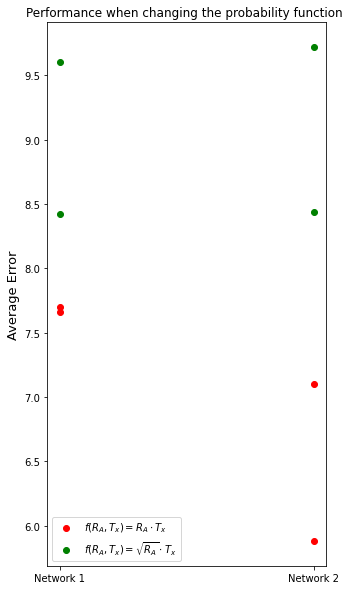

In [32]:
x = ["Network 1","Network 2","Network 3","Network 4","Network 5"]
plt.figure(figsize=(5,10))
for g in range(0,num_graph):
    for m in range(0,num_test):
        plt.scatter([x[g]],Results2[g,m,0],color = "red")
        plt.scatter([x[g]],Results2[g,m,1],color = "green")
plt.scatter([],[],color = "red", label = "$f(R_A,T_x) = R_A \cdot T_x$")
plt.scatter([],[],color = "green", label = "$f(R_A,T_x) = \sqrt{R_A} \cdot T_x$")
        
plt.ylabel("Average Error", fontsize = 13)
plt.title("Performance when changing the probability function ", fontsize = 12)
plt.legend()
plt.show()

In [33]:
# We now run the analysis with four different distributions 
# Same as before but change the distributoion Tran() not func()
num_graph = 1 #5
num_test  = 2 #5
Results3 = np.zeros([num_graph,num_test,4])
def func(Influence, tran):
        return bernoulli.rvs( Influence*tran )
def Tran():
        return np.random.uniform(0,1)

In [34]:
# Originally the three new distributions were done seperatley but have been added togeather to save time
global nodes, net, N_I, N_O, tabel, top

nodes = 700
conections = 3
trials = 100
top = 100


for graph in range(0,num_graph):    
    
    [net, N_I, N_O] = make_grid(nodes,conections )
   
    T_R = [(i,j) for i,j in zip(N_I[0:100],np.arange(0,100))]
    T_R.sort()
    T_R.reverse()
    
    def Tran():
        return np.random.uniform(0,1)
    
    for test in range(0,num_test):
        tabel = []
        for i in range(0,top):
            tabel.append([])
        al2()
        
        A1_R = anaylsis3()
        
        p_dif1 = np.zeros(top)
        
        for i in range(0,top):
            ti = T_R.index((N_I[i],i))
    
            ei1 = A1_R.index((N_I[i],i))
            p_dif1[i] = abs(ti-ei1)

    
        Results3[graph,test,0] = sum(p_dif1)/top    
        
    def Tran():
        return beta.rvs(2,5)
    
    for test in range(0,num_test):
        tabel = []
        for i in range(0,top):
            tabel.append([])
        al2()
        
        A1_R = anaylsis3()
        
        
        p_dif1 = np.zeros(top)
        
        for i in range(0,top):
            ti = T_R.index((N_I[i],i))
    
            ei1 = A1_R.index((N_I[i],i))
            p_dif1[i] = abs(ti-ei1)

    
        Results3[graph,test,1] = sum(p_dif1)/top  
        
    def Tran():
        return beta.rvs(5,2)
    
    for test in range(0,num_test):
        tabel = []
        for i in range(0,top):
            tabel.append([])
        al2()
        
        A1_R = anaylsis3()
        
        
        p_dif1 = np.zeros(top)
        
        for i in range(0,top):
            ti = T_R.index((N_I[i],i))
    
            ei1 = A1_R.index((N_I[i],i))
            p_dif1[i] = abs(ti-ei1)

    
        Results3[graph,test,2] = sum(p_dif1)/top  
        
    def Tran():
        return beta.rvs(5,5)
    
    for test in range(0,num_test):
        tabel = []
        for i in range(0,top):
            tabel.append([])
        al2()
        
        A1_R = anaylsis3()
        
        
        p_dif1 = np.zeros(top)
        
        for i in range(0,top):
            ti = T_R.index((N_I[i],i))
    
            ei1 = A1_R.index((N_I[i],i))
            p_dif1[i] = abs(ti-ei1)

    
        Results3[graph,test,3] = sum(p_dif1)/top  
        

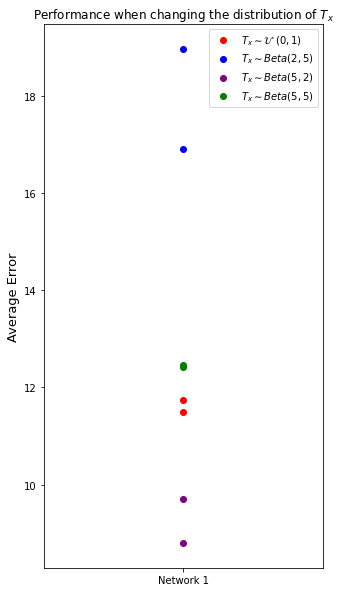

In [35]:
# In the report these were printed out on 3 differnt graphs but here is them all on one
x = ["Network 1","Network 2","Network 3","Network 4","Network 5",]
plt.figure(figsize=(5,10))
for g in range(0,num_graph): 
    for m in range(0,num_test):
        plt.scatter([x[g]],Results3[g,m,0],color = "red")
        plt.scatter([x[g]],Results3[g,m,1],color = "blue")
        plt.scatter([x[g]],Results3[g,m,2],color = "purple")
        plt.scatter([x[g]],Results3[g,m,3],color = "green")
plt.scatter([],[],color = "red", label = "$T_x \sim \mathcal{U} \ (0,1)$")
plt.scatter([],[],color = "blue", label = "$T_x \sim Beta(2,5)$")
plt.scatter([],[],color = "purple", label = "$T_x \sim Beta(5,2)$")
plt.scatter([],[],color = "green", label = "$T_x \sim Beta(5,5)$")
        
plt.ylabel("Average Error", fontsize = 13)
plt.title("Performance when changing the distribution of $T_x$ ", fontsize = 12)
plt.legend()
plt.show()

## Random function
This is the part that I can't seem to fix it

In [36]:
"""
global nodes, conections, trials, top
nodes = 100
conections = 3
top = 100
trials = 200
"""

'\nglobal nodes, conections, trials, top\nnodes = 100\nconections = 3\ntop = 100\ntrials = 200\n'

In [37]:
"""
# change the function to be the random function
def func(R, T):
    #infect = rand_func(R,T)
    return R*T
def Tran():
        return np.random.uniform(0,1)
"""

'\n# change the function to be the random function\ndef func(R, T):\n    #infect = rand_func(R,T)\n    return R*T\ndef Tran():\n        return np.random.uniform(0,1)\n'

In [38]:
"""
number_of_funcs = 2 # select how many random functions you want to be used
                    # 10 were used in the project but it takes a while
Results4 = np.zeros([number_of_funcs,5])
"""

'\nnumber_of_funcs = 2 # select how many random functions you want to be used\n                    # 10 were used in the project but it takes a while\nResults4 = np.zeros([number_of_funcs,5])\n'

In [39]:
# Make a new network and generates the correct order
# Below is the test for simple influence over different values of lambda.
# Initially, the results from ordering all 100 nodes and ordering the bottom 75 were done seperatley.
# I've combined them for speed.

"""


global net, N_I, N_O, tabel, top, nodes
[net, N_I, N_O] = make_grid(nodes,conections)
T_R = [(i,j) for i,j in zip(N_I[0:100],np.arange(0,100))]
T_R.sort()
T_R.reverse()

for fu in range(0,number_of_funcs):
    print("function:", fu+1)             # These were used to follow where in the tests the program is at, these can be muted
    
    rand_func(0.5,0.5, choice ="new")    # reset the new function
    
    tabel = []                           # reset the tabel before every new function 
    for make in range(0,top):
        tabel.append([])
    
    
    for test in range(0,5):
        print("depth: ", 200*(test+1))   # can be muted
        
        al2()                            # This contiousley builds on the data already in tabel.
                                         # on the first run tabel will have 200 messgaes
                                         # The second run will add 200 messages to tabel
        A1_R = anaylsis3()
        p_dif1 = np.zeros(top)
        
        for i in range(0,top):
            ti = T_R.index((N_I[i],i))
            ei1 = A1_R.index((N_I[i],i))
            p_dif1[i] = abs(ti-ei1)
            
        Results4[fu,test] = sum(p_dif1)/top
    print()                              # can be muted
    
"""

'\n\n\nglobal net, N_I, N_O, tabel, top, nodes\n[net, N_I, N_O] = make_grid(nodes,conections)\nT_R = [(i,j) for i,j in zip(N_I[0:100],np.arange(0,100))]\nT_R.sort()\nT_R.reverse()\n\nfor fu in range(0,number_of_funcs):\n    print("function:", fu+1)             # These were used to follow where in the tests the program is at, these can be muted\n    \n    rand_func(0.5,0.5, choice ="new")    # reset the new function\n    \n    tabel = []                           # reset the tabel before every new function \n    for make in range(0,top):\n        tabel.append([])\n    \n    \n    for test in range(0,5):\n        print("depth: ", 200*(test+1))   # can be muted\n        \n        al2()                            # This contiousley builds on the data already in tabel.\n                                         # on the first run tabel will have 200 messgaes\n                                         # The second run will add 200 messages to tabel\n        A1_R = anaylsis3()\n        p_dif1 =

In [40]:
"""
AR = sum(Results4)/number_of_funcs
"""

'\nAR = sum(Results4)/number_of_funcs\n'

In [41]:
"""
x= [200,400,600,800,1000]
plt.figure(figsize=(10,8))
for i in range(0,number_of_funcs):
    plt.plot(x,Results4[i],linestyle = "-",marker = "o",color = "r",alpha = 0.7)
plt.plot(x,AR,linestyle = "-",marker = "o",color = "k",markersize = 10,linewidth = 3, label = "Average function")
plt.title("Performance of method three, using a\nrandom function with varying amounts of data", fontsize = 20)
plt.ylabel("Average Error",fontsize = 20)
plt.xlabel("Number of messages in the data set",fontsize = 20)
plt.legend(fontsize = 25)
plt.show()
"""

'\nx= [200,400,600,800,1000]\nplt.figure(figsize=(10,8))\nfor i in range(0,number_of_funcs):\n    plt.plot(x,Results4[i],linestyle = "-",marker = "o",color = "r",alpha = 0.7)\nplt.plot(x,AR,linestyle = "-",marker = "o",color = "k",markersize = 10,linewidth = 3, label = "Average function")\nplt.title("Performance of method three, using a\nrandom function with varying amounts of data", fontsize = 20)\nplt.ylabel("Average Error",fontsize = 20)\nplt.xlabel("Number of messages in the data set",fontsize = 20)\nplt.legend(fontsize = 25)\nplt.show()\n'

# Simple Influence 

In [42]:
def func(R,T):
    return R*T
def Tran():
    return np.random.uniform(0.35,0.65)  

In [43]:
# For the sake of the new type of analysis, a new spread function is made
# It works identically but just stores different data
# That being, at what point was each node infected, stored in wave
# The nodes in the same wave send their messages simultaneously. However, the old program didn't account for this

def spreadcon(origin,net,I_S, tran):
    global nodes
    I = np.zeros(nodes) 
    add = [origin]              # List of infected waiting to send message
    I[origin] = 1               # Initialise the infected with origin node
    wave = {0: [origin]}        
    w = 0
    while add != []:
        I, add = swave(wave[w],net, I_S,tran, I) # Input the next wave of people wave[w], and the current infected, I
                                                 # Output the new list of infected I, and the new nodes to infect, add
        w +=1                                    # Next wave
        wave[w]= add
                                     
    return I , wave 

def swave(W,net,I_S,tran, I):   # This function is a way to split up the waves
                                # We can no longer continuously add nodes to waiting
                                # Run the infection on one wave of nodes while building up the next wave of nodes
    Waiting = []
    for i in W:
        for j in range (0,nodes):
            f_RT = func(I_S[i],tran)
            if net[i,j]==1:
                if I[j]==0:
                    infect = bernoulli.rvs(f_RT)
                    if infect:
                        Waiting.append(j)
                        I[j] = 1
    return I, Waiting

In [44]:
# To speed up the program i've used 400 nodes, it can be reverted back to the original 700
global nodes, conections, net, N_I, N_O
nodes = 400               
connections = 3

[net, N_I, N_O] = make_grid(nodes,connections)

In [45]:
# The Reputation values had a physical number to compare back to
# Simple Influence does not have this. To estimate a value of simple influence we manually 
# send multiple messages from each node and average out the results
# This function does that for the top 100 nodes

def SCT(t):
    global nodes, net, N_I
    contagion = np.zeros(top)               
    for j in range(0,top):                  # Cycle through each node
        for test in range(0,t):             # repeat t times
            I,w = spreadcon(j,net,N_I, 0.5)
            contagion[j] += sum(I)          # Collect all the values
            
    return contagion/t                      # Average out the results


In [46]:
# As the SI values are estimated stochastically, there will be variance within the results
# To measure this, we can generate two sets of "true values" TR1 and TR2, then compare the results
# Warring, this takes a long time.
t = 50
TR1 = SCT(t)
print("First set done")
TR2 = SCT(t)
print("Second set done")
global top
LT1 = []
LT2 = []
for i in range(0,top):
    LT1.append((TR1[i],i))
    LT2.append((TR2[i],i))

LT1.sort()
LT2.sort()

T1=np.zeros([top,2])
T2=np.zeros([top,2])
for i in range(0,top):
    T1[i,0]=LT1[i][0]
    T1[i,1]=LT1[i][1]
    T2[i,0]=LT2[i][0]
    T2[i,1]=LT2[i][1]
    
Diffy = np.zeros(top)
for i in range(0,top):
    t1 = np.where(T1 == i)[0][0]
    t2 = np.where(T2 == i)[0][0]
    t3 = abs(t1-t2)
    Diffy[i]=t3
print(sum(Diffy)/top)       # This is the average difference in position ideally this would be as close to zero as possible
                            # This is a measuure of how much the two sets agree
#print(Diffy)

First set done
Second set done
5.27


The method developed to analyse simple influence is named the *lambda method* . It has a parameter *L* that affects the analysis. Not only do we want to measure the method's performance, but we would also like to measure the performance with varying values for *L*. 


To do this, we first need a program that generates the data set for the *lambda method*. By separating this part of the program from the *lambda method*, we can run the *lambda method* on the same dataset for multiple values of *L*.

The program that does this is SCA1. It builds a data set from *tr* messages

In [47]:
def SCA1(tr):
    global net, N_I, top
    con_est = np.zeros([top,6])
    for trial in range(0,tr):                 # for tr messages
        origin = random.randint(0, top-1)     # pick origin
        tran = Tran()                         # pick transmisibility of message
        I,W = spreadcon(origin,net,N_I, tran) # Spread the message
        s = sum(I)                            # Sum number of infected
        
        
        for w in W:    # Cycle through waves (Errors occour if I set it to 3 waves and there is only 2 waves)
            if w == 3: # Beyond the waves the relationship is minimal
                break
            for i in W[w]:    # Go through all nodes in the wave
                if i < top:   # Check we're doing analysis
                    con_est[i,w]+= s    # Add s to node's wave tottal
                    con_est[i,3+w]+= 1  # Record how many sums have been added to averge out later

    return con_est 

In [48]:
def lambda_method (gridT,L): # gridT will be output from SCA1, L is "lambda value"
    global top
    out = np.zeros(top)
    grid = np.copy(gridT)   # Don't want to affect gridT as we use it for multiple values of L
    for i in range(0,top):
        bottom = 0
        for j in range(0,3):
            out[i]+=(L**j)*grid[i,j]   # Sum the number of infections with weighting L**j
            bottom+=(L**j)*grid[i,j+3] # This will be used to normalise the out value
        out[i]=out[i]/bottom           # Normalise
    return out

In [49]:
# If TR1 was not generated before then un comment and run it here
#TR1 = SCT(50)

In [50]:
num_tests = 5
global top
LTO=[]                     # Puts TR1 into correct order
for i in range(0,top):        
    LTO.append((TR1[i],i))
LTO.sort()

Bank1 = np.zeros([num_tests,10]) # Store results for all node
Bank2 = np.zeros([num_tests,10]) # Store results for bottom 75 nodes

        
for b in range(0,num_tests):
    t1 = SCA1(500)          # build data set
    t3 = np.zeros([10,100])
    l = [0,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.65,0.8] # Selcet values of L to test
    for j in range(0,10) :
        t3[j,:]= lambda_method(t1,l[j]) # Use lambda method with all values of L
    
    LO = [[],[],[],[],[],[],[],[],[],[]] 
    for j in range(0,10): 
        for i in range(0,top):
            LO[j].append((t3[j,i],i))   # Order the results for all vlaues of L
        LO[j].sort()
        
    O = np.zeros([10,top])              # Use same comparison method as before
    TO= np.zeros([top])

    for i in range(0,top):
        for j in range(0,10):
            O[j,i] =LO[j][i][1]
        TO[i]=LTO[i][1]

    C_dif1=np.zeros([10,top])
    C_dif2=np.zeros([10,top])
    for i in range(0,top):
        ti  = np.where(TO==i)[0][0]
        for j in range(0,10):
            ei = np.where(O[j] ==i)[0][0]
            C_dif1[j,i]=abs(ti-ei)
            
            if ti<75:                   # Add this for the bottom 75 test
                C_dif2[j,i]=abs(ti-ei)  
    
    ACD1 = np.zeros(10)
    ACD2 = np.zeros(10)
    for j in range(0,10):
        ACD1[j] = sum(C_dif1[j,:])/100    
        ACD2[j] = sum(C_dif2[j,:])/75
    Bank1[b,:] = ACD1
    Bank2[b,:] = ACD2


C:\Users\lucad\AppData\Local\Temp/ipykernel_16188/2137224099.py:10: RuntimeWarning: invalid value encountered in double_scalars
  out[i]=out[i]/bottom           # Normalise


In [51]:
BA1 = sum(Bank1)/num_tests
BA2 = sum(Bank2)/num_tests

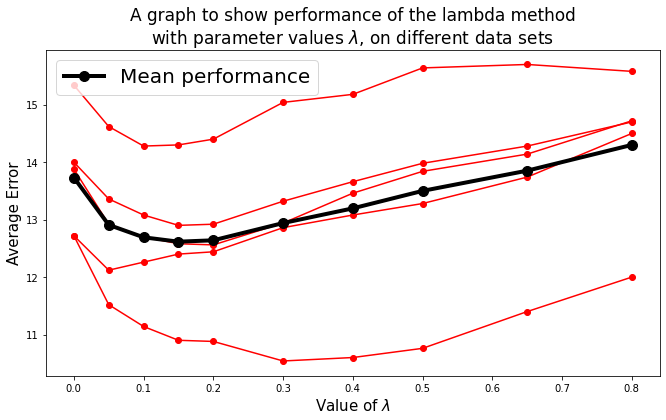

In [52]:
plt.figure(figsize=(11,6))
for j in range(0,num_tests):
    plt.plot(l,Bank1[j,:],linestyle = "-",marker = "o", color = "r")
plt.plot(l,BA1,linestyle = "-",marker = "o", color = "k", label = "Mean performance",markersize = 10,linewidth=4)
plt.legend(fontsize = 20)
plt.title("A graph to show performance of the lambda method\nwith parameter values $\lambda$, on different data sets", fontsize = 17)
plt.ylabel("Average Error",fontsize = 15)
plt.xlabel("Value of $\lambda$",fontsize = 15)
plt.show()

In [53]:
LTO.reverse()

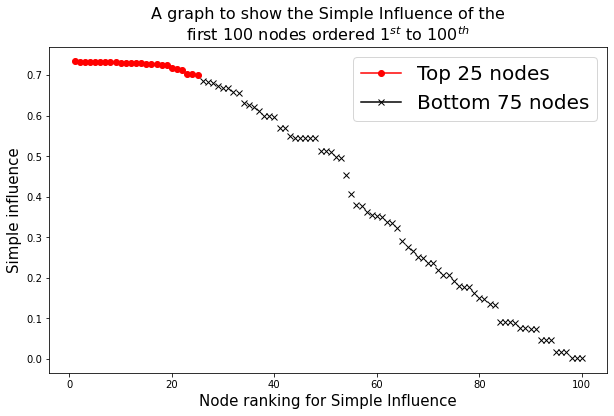

In [54]:
plt.figure(figsize = (10,6))
for i in range(0,25):
    plt.plot(i+1,LTO[i][0]/nodes,marker="o",color="r")

for i in range(25,100):
    plt.plot(i+1,LTO[i][0]/nodes,marker="x",color="k")
plt.plot([],[],marker="o",color="r", label = "Top 25 nodes")
plt.plot([],[],marker="x",color="k", label = "Bottom 75 nodes")
plt.legend(fontsize = 20)
plt.ylabel("Simple influence",fontsize = 15)
plt.xlabel("Node ranking for Simple Influence",fontsize =15)
plt.title("A graph to show the Simple Influence of the\nfirst 100 nodes ordered $1^{st}$ to $100^{th}$", fontsize=16)
plt.show()

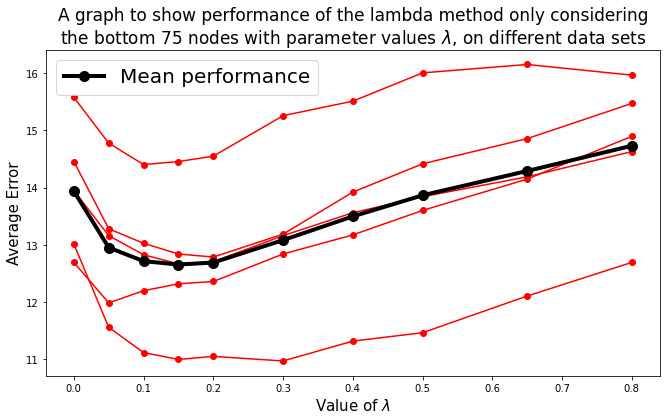

In [55]:
plt.figure(figsize=(11,6))
for j in range(0,num_tests):
    plt.plot(l,Bank2[j,:],linestyle = "-",marker = "o", color = "r")
plt.plot(l,BA2,linestyle = "-",marker = "o", color = "k", label = "Mean performance",markersize = 10,linewidth=4)
plt.legend(fontsize = 20)
plt.title("A graph to show performance of the lambda method only considering\nthe bottom 75 nodes with parameter values $\lambda$, on different data sets", fontsize = 17)
plt.ylabel("Average Error",fontsize = 15)
plt.xlabel("Value of $\lambda$",fontsize = 15)
plt.show()

# Complex Contagion

In [61]:
# For complex contagion we need a threshold for each node, N_T
global N_T, S_N_T, S_net, S_N_O

[s_net, S_N_I,S_N_O] = make_grid(30,3)

N_T = np.random.uniform(0.1,0.9,nodes) # For the actual network
S_N_T = np.random.uniform(0.2,1,30)    # For a diagram 

In [57]:
# This is a program that runs complex contagion on a network for a given origin set
# The program works by looking at a set of newly infected nodes
# The introduction of these nodes to the infected population means nodes connected to them
# have the potential to go beyond their infection threshold
# Looking at these potential infected nodes, we go through them one by one
# Adding them to a list of new infected nodes if they have gone beyond their threshold 

def comp_spread(origin):
    global net, nodes, N_T, N_O
    I = np.zeros(nodes)           # List of infected nodes
    for i in origin:              # Set the infected nodes to be the origin
        I[i] = 1
    new_infect = origin           # Set new infected nodes to be origin
    new_hit = set({})             # new_hit is the list of potentially infected nodes
    infect_add = []               # Used to store the new infections while we go through the old ones
    
    while new_infect!=[]:
        for i in new_infect:
            for j in range(0,nodes):
                if net[i,j]==1 and I[j]==0:    # Check conected and suseptable
                    new_hit.add(j)             # Add to new potentialy infected nodes
        
        for j in new_hit:                      # Go through all the potential nodes
            s = sum(I*net[j,:])                # Number of infected nodes connected
            fr = s/N_O[j]                      # Fraction of the connected nodes that are infected
            if fr > N_T[j]:                    # If over the threshold
                infect_add.append(j)           # j will become infected
                
        new_hit=set({})                        # Reset the potentially infected nodes
        new_infect = infect_add                # Set the new infected nodes to be the nodes recently infected
        for i in infect_add:                   # Update the list of infected nodes
            I[i]=1
        infect_add = []                        # Reset the nodes that will be infected
    return I
        

In [58]:
# same function as above however prints out images to show the infections
def graph_comp_spread(origin):
    global S_net, S_N_T, S_N_O
    I = np.zeros(30)
    for i in origin:
        I[i] = 1
    new_infect = origin
    new_hit = set({})
    infect_add = []
    
    while new_infect!=[]:
        for i in new_infect:
            for j in range(0,30):
                if S_net[i,j]==1 and I[j]==0:
                    new_hit.add(j)
        
        for j in new_hit:
            s = sum(I*S_net[j,:])
            r = s/S_N_O[j]
            if r > S_N_T[j]:
                infect_add.append(j)
                
        
        draw_graph3( I, infect_add)        
        
        new_hit=set({})        
        new_infect = infect_add
        for i in infect_add:
            I[i]=1
        infect_add = []
    return 

def draw_graph3( infected, infected_add, labels=None, graph_layout='shell',
               node_size=200, node_text_size=20,
               edge_color='black', edge_alpha=None, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):

    global S_net
   
    # create networkx graph
    G=nx.Graph()
    
    graph = []
    for i in range(0,29):
        for j in range(i+1,30):
            if S_net[i,j]==1:
                graph.append((i,j))
    
    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
  
    graph_pos=nx.shell_layout(G)
        
    plt.figure(figsize=(10,7))    
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, alpha=0, node_color="w")
    

    # draw graph
    
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)

    for i in range(0,30):
        if sum(S_net[i,:])!= 0:
            S=nx.Graph()
            S.add_edge(i,i)
            nx.draw_networkx_nodes(S,graph_pos,node_size=node_size, alpha= S_N_T[i], node_color="k")
    
    I=nx.Graph() 
    for i in range(0,30):
        if infected[i]==1:            
            I.add_edge(i,i)
    nx.draw_networkx_nodes(I,graph_pos,node_size=node_size, alpha=1, node_color="red", label= "Infected")
    
    IA = nx.Graph()
    for i in infected_add:
        IA.add_edge(i,i)
    nx.draw_networkx_nodes(IA,graph_pos,node_size=node_size, alpha=1, node_color="pink", label = "Infected (new)")

    
    plt.legend()
    plt.show()


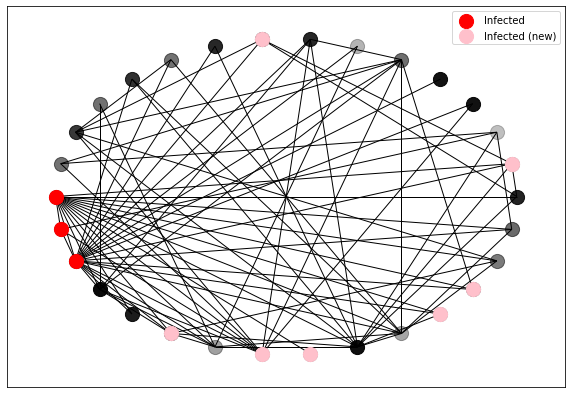

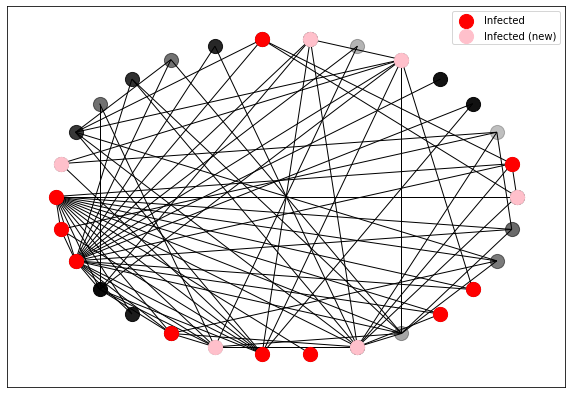

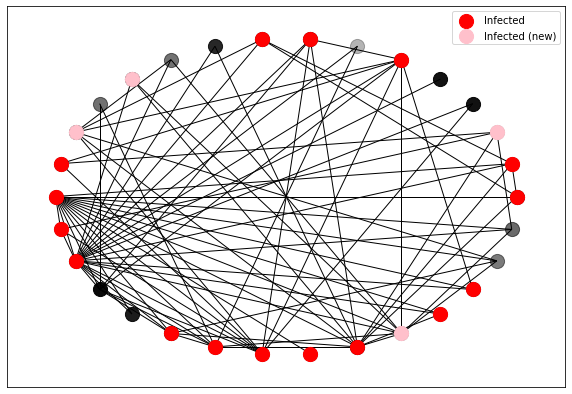

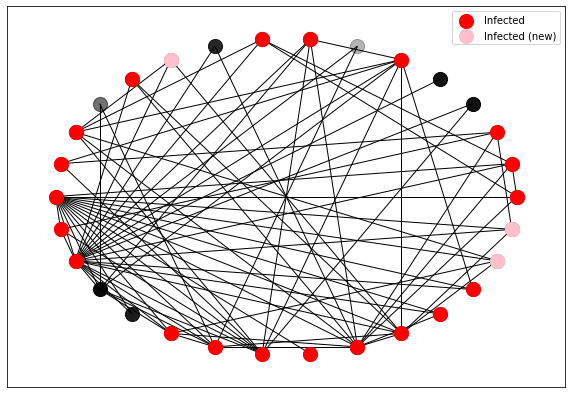

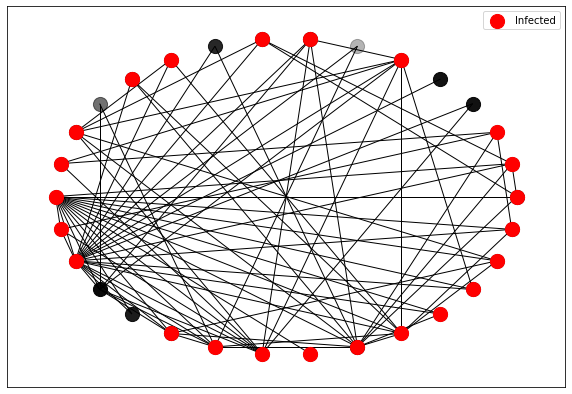

In [62]:
# This runs the comp spread program and outputs images displaying the spread
# Feel free to experiment with differnet starting nodes 
O1 = 0
O2 = 1
O3 = 2                       
graph_comp_spread([O1,O2,O3])

# Using simple anaylis on complex contagion

In [63]:
# This was made to see what would happen if the analysis for reputation was used on the complex contagion model
# simp_comp_spread is the same as comp_spread however it saves the waves nodes were infected on, in waves
def simp_comp_spread(origin):
    global net, nodes, N_T, N_O
    I = np.zeros(nodes)
    for i in origin:
        I[i] = 1
    new_infect = origin
    new_hit = set({})
    infect_add = []
#        
    waves = {0:origin}
    wave = 1
#
    while new_infect!=[]:
        for i in new_infect:
            for j in range(0,nodes):
                if net[i,j]==1 and I[j]==0:
                    new_hit.add(j)
        
        for j in new_hit:          
            s = sum(I*net[j,:])
            r = s/N_O[j]
            if r > N_T[j]:
                infect_add.append(j)
#                
        waves[wave]=infect_add        # saves infect_add
        wave+=1
#                
        new_hit=set({})        
        new_infect = infect_add
        for i in infect_add:
            I[i]=1
        infect_add = []
    return I, waves, wave

# Unlike with simple reputation, a node can help infect another node a long time in the future 
# This function is used to go through wave by wave, node by node, to check what nodes each node helped to infect
def SC_al1(I, waves, W):
    global net, nodes
    
    tally = np.zeros([nodes])
    ratio = np.zeros([nodes])
    ratio -= 1
    
    for w in range(0,W):                  # For each wave
        for i in waves[w]:                # For each node in that wave
            for Nw in range(w+1,W):       # Check all future waves of infected nodes
                                          # These are the nodes that node i helped infect
                for j in waves[Nw]:       # For all j in Nw, j is infected
                    if net[i,j]==1:       # Check j and i are connected, hence that i helped infected j
                        tally[i] += 1     # add to i's tally
                        
    fade = np.copy(net)                   # The next part requires edditing net 
                                          # we don't want to ruin net so make a copy
                                          # A node can only help infect the suseptible nodes it is connected to
                                          # The ratio of infected nodes is then how many i helped infectd
                                          # versus the nodes the could of been infected
    for w in range(0,W):
        for i in waves[w]:
            fade[:,i] = 0                 # Remove the conections of unsuseptible nodes, as i could not help infect these
        for i in waves[w]:
            check = np.sum(fade[i,:])     # Check i actually had a chance to infect other nodes
            if check != 0:
                ratio[i]=tally[i]/check   # tally = nodes helped infect and sum(fade) = number of conected suseptible nodes
    return ratio      

def SC_al2():                             # This function averages the ratios from many different runs of SC_al1
    global trials,nodes, top, N_I
    scores = np.zeros([nodes,2])
        
    for t in range(0,trials):
        origin = random.sample(list(np.arange(0,top)) , 10) # Choose random origin
        ill, dic, W = simp_comp_spread(origin)
        add = SC_al1(ill, dic, W)
        for i in range(0,nodes):
            if add[i]!= -1:                # Check it actually was infected
                scores[i,0]+= add[i]
                scores[i,1]+=1
    
    for i in range(0,nodes):
        scores[i,0] = scores[i,0]/scores[i,1] # Average out results                
   
    # This next part is the same as before, putting the results into a list
    # ordering them, then finding the difference in the orders however this is included in the function
    TO = []
    LO = []
    for i in range(0,top):
        TO.append((N_I[i],i))
        LO.append( (scores[i,0], i ))
    
    TO.sort()
    LO.sort()
    T = np.zeros([top,2])
    O = np.zeros([top,2])
    for i in range(0,top):
        T[i,0] =TO[i][0]
        T[i,1] =TO[i][1]
        O[i,0] =LO[i][0]
        O[i,1] =LO[i][1]
    
    C_dif=np.zeros(top)
    for i in range(0,top):
        ti  = np.where(T ==i)[0][0]
        ei1 = np.where(O ==i)[0][0]
        C_dif[i]=np.abs(ti - ei1)
        
    ACD1 = sum(C_dif)/top
    
    return C_dif, ACD1
            

In [64]:
t1, t2 = SC_al2()
print(t1,t2)

[98. 38. 46. 15.  2. 28. 29. 16. 54. 36. 31. 50. 10.  1. 38. 51.  4. 14.
 23. 28. 70. 48. 12. 11. 11.  1. 26. 45. 22. 15. 14.  8.  4. 26. 15.  6.
 45.  7. 13.  7. 57. 40. 20. 25. 35. 47. 29. 13. 21. 60. 32. 14. 50. 13.
  1. 28. 18. 12.  9. 44. 17.  5. 10. 14. 63. 24. 25. 94.  4. 40.  2. 40.
 14. 27.  3. 31. 51. 21. 47. 27.  1. 56. 17. 63.  2. 13. 17. 17.  1.  2.
 18. 24. 25. 44. 42. 27. 26.  2. 20. 10.] 25.72


C:\Users\lucad\AppData\Local\Temp/ipykernel_16188/1940758119.py:82: RuntimeWarning: invalid value encountered in double_scalars
  scores[i,0] = scores[i,0]/scores[i,1] # Average out results


# Finding multiple influencers

Together, the following two functions find the eigenvalue of the matrix M from the paper referenced in the report. make_B makes the non-backtracking matrix. Then eig_perc removes the edges of the nodes in N and then calculates the eigenvalue. 

In [65]:
def make_B():
    global net, nodes, B, B_D, m
    
    m = int(np.sum(net))       # 2* Number of edges (Each edge is repersented in net twice hence m is 2* num edges)
    B_D = {}                   # Make a convertion between the numbers 0 -> m and the edges
    e = 0
    for i in range(0,nodes):
        for j in range(0,nodes):
            if net[i,j] == 1:
                B_D[e] = (i,j)  # each edge (i,j) is represented by a number in B_D
                e +=1
    B = np.zeros([m,m])
    for i in range(0,m):        # loop through each pair of edges
        for j in range(0,m):
            if (B_D[i][1]==B_D[j][0]) and (B_D[i][0]!=B_D[j][1]): # Non-Backtracking condition
                B[i,j] = 1
    return 

def eig_perc(N):
    global B_D,B,m
    
    M = np.copy(B)                # Don't want to have to keep making B so we copy it
                                  # Now all we have to do is run make_B() once, then eig_perc for every set N
    for remove in N:              # Removes every edge "remove" is in
        for s in range(0,m):
            if B_D[s][1]==remove:
                M[s,:]=0
            if B_D[s][0]==remove:
                M[:,s]=0
    
    eig = LA.eigvals(M)           # eig is the set of all eigenvalues of M
    return np.max(eig)            # return the largest
    

Bellow was my testing of the eigenvalue predictions. I printed out the order of the first 50 nodes and then chose four pairs of nodes with a similar number of connections. The numbers in the sets SA and SB would have to be chosen again depending on the network used. 

Note the set with the lower eigenvalue is predicted to infect more nodes. 

In [66]:
make_B() # must run make_B before running eig_perc

In [67]:
print(N_O[0:50]) # Use this if you wish to pick two sets A and B to test

[171.  30.   9. 116.   3.  22.  17.  14.   5.   5.  68.  15.  23.  37.
   3.   4.  67.  51.   9.   7.   6.   3.   2.   3.   4.  29.   6.  14.
  25.  11.  15.  17.  26.   2.  11.  10.   3.   9.   6.   6.   5.   2.
  19.   6.   3.  24.  19.   3.  31.   7.]


In [68]:
SA = [0,23,25,22]
SB = [46,38,36,48]

In [69]:
print("Node order Set A:",N_O[SA[0]],N_O[SA[1]],N_O[SA[2]],N_O[SA[3]])
print("Node order Set B:",N_O[SB[0]],N_O[SB[1]],N_O[SB[2]],N_O[SB[3]])
print()
print("Eigen Val  Set A:",np.round(eig_perc(SA),3))
print("Eigen Val  Set B:",np.round(eig_perc(SB),3))
print()
print("Infected   Set B:",np.sum(comp_spread(SA)))
print("Infected   Set B:",np.sum(comp_spread(SB)))

Node order Set A: 171.0 3.0 29.0 2.0
Node order Set B: 19.0 6.0 3.0 31.0

Eigen Val  Set A: (11.547+0j)
Eigen Val  Set B: (14.988+0j)

Infected   Set B: 58.0
Infected   Set B: 11.0


# Collective influence

topn finds the index of the biggest n elements from a list

In [70]:
def topn(List,n):
    O = np.sort(List)   # O has the largest elements at the end
    tn = []             # This will be the outputed indexs
    count = 0           # This is the number of elements in the list
    index = -1          # This is how far along O we are looking for elements (Biggest are at the end hence -1)
    while count < n:
        add = np.where(List==O[index])[0] # add can contain multiple positions for where O[index] is
                                          # We add all the indexs we can until we have n indexs
        for i in add:
            tn.append(i)   # Add index to list
            count +=1      # Increase the count by 1
            
            index -=1      # The position we want to search for our next elements will go back by one
                           # Hence if add has 2 elements we move the next search back by 2 places
                           # If we always move the search back by one, after searching for O[-1] we would seach for O[-2]
                           # if add had two elements O[-2] will be the same as O[-1]. So O[-1] and O[-2] will get added again
                           # Instead our next search will actually be for O[-3], as both O[-1] and O[-2] are already in the list
                            
            if count == n: # Break once we have enough 
                break
    return tn    

findbest was a function made to do some preliminary testing. The idea was to take the trivial solution (n most connected nodes). Then using brute force, test other possible configurations of nodes by searching in the pool of the top 3*n connected nodes. 

In [71]:
def findbest(N_O,n):
    trivial = topn(N_O,n)              # Trivial soultion
    compete = topn(N_O,3*n)            # This list is the list of elements we want to test
    best = np.sum(comp_spread(trivial))# Find score to beat
    print("trivial:",trivial,best) 
    # Rather than looking for all possible permutations of compete. We look to improve the trivial solution 
    # in the last two positions, the assumption being the elements with fewer connections will be less crucial.
    # Therefore, it will be easier to find better replacements
                                       
    for i in range(n-1,3*n - 1):       
        del trivial[-2]               # remove the second last element 
        trivial.insert(-1,compete[i]) # Insert potential improvment 
        for j in range(i+1,3*n):      # go from i to avoid repeats
            del trivial[-1]           # remove last element
            trivial.append(compete[j]) # insert potential improvement 
            if np.sum(comp_spread(trivial)) >= best: # if better than the trivial solution
                if np.sum(comp_spread(trivial)) > 500:  # This was to print out any solutions that reach a bifurcation point
                    print(trivial)
                print(i, j, np.sum(comp_spread(trivial)))
        

In [72]:
#findbest(N_O,10)

all_col_inf finds the collective influence of all nodes in a network at depth L. 

In [73]:
def all_col_inf(L,net):    # depth = L
    global nodes,top, N_O
    
    N  = np.zeros([nodes,nodes,L])
    N[:,:,0] = np.copy(net)
    for l in range(1,L):
        N[:,:,l] = np.matmul(N[:,:,l-1],N[:,:,0]) 
        # N^l (i,j) gives the number of paths between i and j of length l
        # If this is unclear say and i can explain how it works
        # N[:,:,l] is then equal to N^l
    
    dBall = np.zeros([nodes,nodes]) # This will be the edge at length L
    for i in range(0,nodes):        
        for j in range(0,nodes):
            for z in range(0,L-1): # For all the depths lower than L
                if N[i,j,z]!= 0:   # Check their exist no paths (Must only be conected by paths of length L and higher)
                    break          
            else:
                if N[i,j,L-1] != 0:# Check their exist atleast one path of length L
                    dBall[i,j] = 1 # Add this to dBall
                                    
    a_c_inf = np.zeros(top)        # This comes from the formula in the paper
    for x in range(0,top):         # Calculate the colective influence of x
            for j in range(0,nodes):
                if dBall[x,j] ==1:          
                    a_c_inf[x] += N_O[j]-1
            a_c_inf[x] = a_c_inf[x]*(N_O[x] - 1)
    return a_c_inf                # a_c_inf returns all the colective influences

CItopn finds the n nodes with the biggest collective influence. This is done iteratively. i.e. the node with the biggest collective influence is chosen, then this node is removed from the network, and the collective influences are re-calculated

In [74]:
def CItopn(L,n):    
    global net,nodes,top, N_O
    Nodes = []
    nett = np.copy(net)         # dont want to alter net so make a copy of it
    for i in range(0,n):
        CI = all_col_inf(L,nett) # calculate the colective influence of all nodes in nett
        N =topn(CI,1)[0]         # Find the best one
        Nodes.append(N)          # Add this to our list
        nett[N,:]=0              # remove it from net then recalculate
        nett[:,N]=0
    return Nodes

CItopn is the method used in the paper I referenced in the report. Alongside this, I use another method. The other method doesn't iteratively calculate collective influence values. It does one iteration of all_col_inf, and then chooses the top n values from this list. The benefit is much quicker run times. Some preliminary testing showed that the set of nodes obtained from these two methods was very similar. See below.

In [75]:
test1 = all_col_inf(1,net)
test2 = all_col_inf(2,net)
test3 = CItopn(1,15)
test4 = CItopn(2,15)

In [76]:
a = 12
t0 = topn(N_O,  a)
print(t0)
print()

l1 = topn(test1,a)
print(l1)
l2 = topn(test2,a)
print(l2)
print()

C1 = test3[0:a]
print(C1)
C2 = test4[0:a]
print(C2)

[0, 3, 10, 16, 17, 13, 48, 1, 25, 32, 28, 45]

[0, 3, 10, 16, 17, 1, 13, 48, 28, 25, 5, 12]
[0, 3, 10, 16, 17, 13, 48, 25, 1, 32, 28, 61]

[0, 3, 10, 16, 17, 13, 1, 25, 48, 32, 28, 61]
[0, 3, 10, 16, 17, 13, 1, 25, 48, 32, 61, 28]


In [77]:
print(np.sum(comp_spread(t0)))
print(np.sum(comp_spread(l1)))
print(np.sum(comp_spread(l2)))
print(np.sum(comp_spread(C1)))
print(np.sum(comp_spread(C2)))

305.0
327.0
305.0
305.0
305.0


Below is my test for the depth to use in CItopn. The quicker version is used in the test.

In [78]:
ldepth=np.zeros([3,10])

global net, N_I, N_O, nodes, N_T
nodes = 400
conections = 3

num_net = 3

for i in range(0,num_net):
    [net, N_I, N_O] = make_grid(nodes,conections)
    
    # These are the colective influences at the three depths    
    test1 = all_col_inf(1,net)   
    test2 = all_col_inf(2,net)
    test3 = all_col_inf(3,net)
    
    # Finds the top 15 nodes at these depths
    t1 = topn(test1,15)
    t2 = topn(test2,15)
    t3 = topn(test3,15)
    for j in range(0,10): # calculates performance with differnt number of nodes
        ldepth[0,j] += np.sum(comp_spread(t1[0:1+j])) 
        ldepth[1,j] += np.sum(comp_spread(t2[0:1+j]))
        ldepth[2,j] += np.sum(comp_spread(t3[0:1+j]))   
ldepth = ldepth/num_net

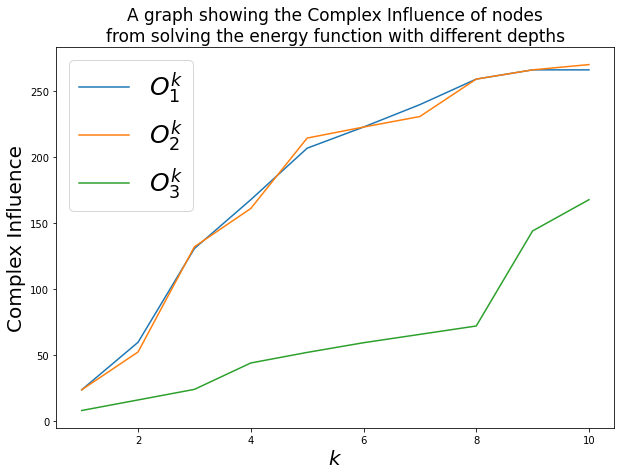

In [79]:
x = [1,2,3,4,5,6,7,8,9,10]
la = ["$O_1^k$","$O_2^k$","$O_3^k$"] 
plt.figure(figsize = (10,7))
for i in range(0,3):
    plt.plot(x,ldepth[i,:],label = la[i])
plt.legend(fontsize= 25)
plt.xlabel("$k$", fontsize = 20)
plt.ylabel("Complex Influence", fontsize = 20)
plt.title("A graph showing the Complex Influence of nodes\nfrom solving the energy function with different depths", fontsize = 17)
plt.show()

Below are the two tests for the performance of the four methods against the trivial solution. Originally these were done separately. I've combined them to speed up the run time. num_test determines how many tests you want to run. The report used 100, below, it is set to 10 for speed.

In [80]:
num_test = 10 #100 #(Takes a while)

sco  = np.zeros([5,5]) # Performance of the five methods
sco[0,2:5] = num_test  # By defintion these values for the trivial solution will equal 1, set to num_test as we average out later
sco2 = np.zeros([4,5]) # Test the difference to the trivial solution so only needs results for 4 methods

global net, N_I, N_O, N_T, nodes
nodes = 500            # This was set to 700 but again for speed
for t in range (0,num_test):
    [net, N_I, N_O] = make_grid(nodes,conections) 
    
    # I wanted to reduce the effect of randomness from the thresholds 
    # as it's more about evaluating the structure of the network than the threshold values. 
    N_T = np.random.uniform(0.45,0.5,nodes)       
    for a in range(0,20): # Finding the bifurcation point of the trivial solution
        t0 = topn(N_O,a)
        st = np.sum(comp_spread(t0))
        
        # The network has a problem in that not all nodes are connected
        # so though 500 nodes may potentially be in the network, it is often lower. 
        # 0.7*nodes is used as a boundary for the bifurcation point
        # as more than 70% of potential nodes are always connected (commonly 90%)
        if st>nodes*0.7: 
            tO = np.sum(N_O[t0])
            A  = a # A is the bifurcation point
            break
    test1 = all_col_inf(1,net)
    test2 = all_col_inf(2,net)
    
    # Run CItop once with A+2 nodes, as the values for A-2 -> A+1 can also be inferred from this
    test3 = CItopn(1,A+2)
    test4 = CItopn(2,A+2)
    
    # Complex influence for trivial solution one and two nodes before A
    # Assume st to be all the connected nodes in the network, then CI is sum of comp_spread/st
    st0 = np.sum(comp_spread(t0[0:A-2])) 
    sco[0,0] += st0/st                   
    st0 = np.sum(comp_spread(t0[0:A-1]))
    sco[0,1] += st0/st
    
    # Method 1
    for i in range(0,5):
        l1 = topn(test1,  A+i-2)       # Go through all the diferent sizes of set relative to A      
        sl1 = np.sum(comp_spread(l1))  # This is for measuring the CI
        if sl1 > nodes*0.7:            # Check for bifurcation
            for j in range(i,5):       # By definition these will equal 1
                sco[1,j] += 1          
            sco2[0,i] += 1             # This is for measuring when the bifurcation point occoured
            break
        else:
            sco[1,i] += sl1/st        # If not a bifurcation, input the CI
            
    # Method 2
    for i in range(0,5):
        l2 = topn(test2,  A-2+i)                
        sl2 = np.sum(comp_spread(l2))
        if sl2 > nodes*0.7:
            for j in range(i,5):
                sco[2,j] += 1
            sco2[1,i] += 1
            break
        else:
            sco[2,i] += sl2/st
            
    # For methods 3 and 4, the set that would be chosen for A-2 -> A+1 nodes
    # is inferred from the set with A+2 nodes by chopping of the end elements.
    # Note, the elements at the start of the list were chosen first. 
    # The list with A+2 nodes is just an extension of the list with A+1 nodes. 
    
    # Method 3
    for i in range(0,5):
        C1 = test3[0:A-2+i]                
        sC1 = np.sum(comp_spread(C1))
        if sC1 > nodes*0.7:
            for j in range(i,5):
                sco[3,j] += 1
            sco2[2,i] += 1
            break
        else:
            sco[3,i] += sC1/st
    
    # Method 4
    for i in range(0,5):
        C2 = test4[0:A-2+i]               
        sC2 = np.sum(comp_spread(C2))
        if sC2 > nodes*0.7:
            for j in range(i,5):
                sco[4,j] += 1
            sco2[3,i] += 1
            break
        else:
            sco[4,i] += sC2/st       
sco = sco/num_test

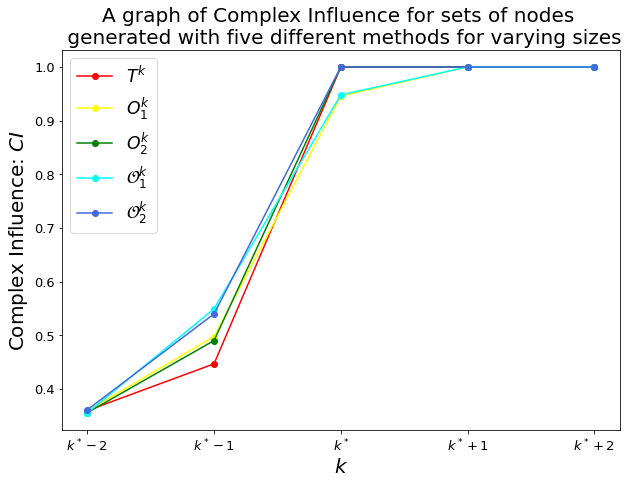

In [81]:
x = ["$k^*-2$","$k^*-1$","$k^*$","$k^*+1$","$k^*+2$"]
cl=["r","yellow","green","aqua","royalblue"]
la=["$T^k$","$O_1^k$","$O_2^k$","$\mathcal{O}_1^k$","$\mathcal{O}_2^k$"]
plt.figure(figsize=[10,7])
for i in range(0,5):
    plt.plot(x,sco[i,0:5],ls="-",marker="o",color = cl[i],label=la[i])
plt.legend(fontsize = "xx-large")
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.xlabel("$k$",fontsize = 20)
plt.ylabel("Complex Influence: $CI$",fontsize = 20)
plt.title("A graph of Complex Influence for sets of nodes \n generated with five different methods for varying sizes", fontsize = 20)
plt.show()

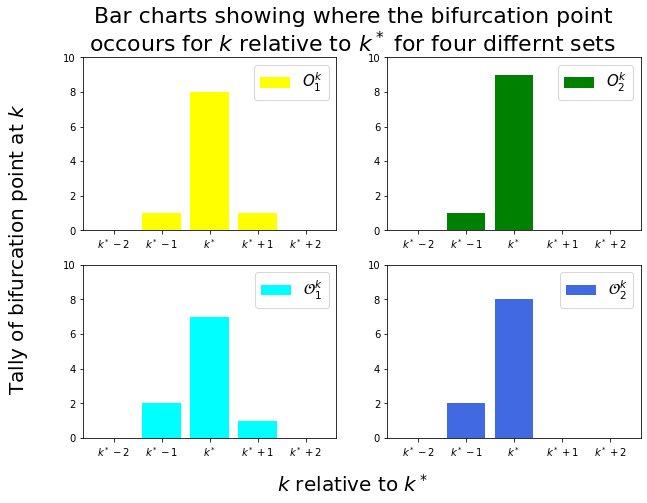

In [82]:
x = ["$k^*-2$","$k^*-1$","$k^*$","$k^*+1$","$k^*+2$"]
cl=["yellow","green","aqua","royalblue"]
la=["$O_1^k$","$O_2^k$","$\mathcal{O}_1^k$","$\mathcal{O}_2^k$"]

fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7))
fig.supylabel('Tally of bifurcation point at $k$', fontsize = 20)
fig.supxlabel('$k$ relative to $k^*$', fontsize = 20)
fig.suptitle("Bar charts showing where the bifurcation point\noccours for $k$ relative to $k^*$ for four differnt sets", fontsize = 22)
for i in range(0,4):
    axes[i//2,np.mod(i,2)].bar(x, sco2[i,:], color = cl[i],label = la[i])
    axes[i//2,np.mod(i,2)].set_ylim([0,num_test])
    axes[i//2,np.mod(i,2)].legend(fontsize = 15)
plt.show()    